# Practical Data Science with Amazon SageMaker
_**Using Amazon SageMaker to solve an end-to-end machine learning problem**_

---

Learn to use Amazon SageMaker for creating, tuning, and deploying a machine learning (ML) model for predicting customer churn of a moblile phone service provider.

## Modules

1. [Prepare a dataset for training](#Prepare-a-dataset-for-training)
2. [Train and evaluate a model](#Train-and-evaluate-a-model)
3. [Automatically tune the model](#Automatically-tune-the-model)
4. [Make the model production ready](#Make-the-model-production-ready)
5. [AWS Auto Scaling](#AWS-Auto-Scaling)
6. [Relative cost of errors](#Relative-cost-of-errors)
  
---

## Prepare a dataset for training

### Churn prediction problem

Losing customers is costly for any business.  Identifying unhappy customers early gives you a chance to offer them incentives to stay.  You will use ML to automate the identification of unhappy customers, also known as *customer churn prediction*. 

ML models rarely give perfect predictions, so you will learn how to adjust for prediction mistakes in your total ML costs.

The example of churn that may be familiar to you; leaving a mobile phone service provider for a competitor.  If a provider is aware that a particular customer is considering leaving, it can offer timely incentives, perhaps in the form of a phone upgrade, to encourage the customer to continue service.  

Incentives are often more cost-effective than losing and reacquiring a customer.

### Dataset

Mobile phone service providers keep historical records on customers who churn bit ultimately continue using the service. You can use this data to construct an ML model of one mobile phone provider's churn using a process called *training*. 

You'll train the model, can pass the profile information of an arbitrary customer to the model, and have the model predict whether this customer is going to churn. The model will make mistakes&mdash;predicting the future is tricky. However, you will learn how to manage prediction errors.

The dataset used is publicly available and is mentioned in the book [*Discovering Knowledge in Data*](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. The author attributed the dataset to the University of California Irvine Repository of Machine Learning Datasets.

As part of the lab setup, the relevant dataset, churn.txt has been downloaded and made available for this exercise.

The above looks like a CSV file with a header row. 

You will use the pandas library for loading and displaying this raw dataset. 

The resulting `churn` variable is a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [1]:
## import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## this line is required by Jupyter to display graphs within the notebook
%matplotlib inline

## changing the style of seaborn for the font size and color
base_color = sns.color_palette()[0]
sns.set(font_scale=1.2)

## this line will change the format of the numpy outputs
np.set_printoptions(precision=3, suppress=True)

## this line will prevent will prevent truncating the columns of the pandas dataframe
pd.set_option('display.max_columns', None)

## get a record of the start time of the notebook
start_time = time.time()

In [2]:
## loading the data into a pandas dataframe
churn = pd.read_csv('churn.txt')

## showing the first 5 lines of the dataframe
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


Let's take a closer look. By modern standards, it’s a relatively small dataset with only 3,333 records. 

Each record uses 21 attributes to describe the profile of a customer of an unknown US mobile phone service provider. 

The attributes are:

- `State`: The US state in which the customer resides indicated by a two-letter abbreviation. For example, OH or NJ
- `Account Length`: The number of days that this account has been active
- `Area Code`: The three-digit area code of the corresponding customer’s phone number
- `Phone`: The seven-digit phone number
- `Int’l Plan`: Whether the customer has an international calling plan: yes/no
- `VMail Plan`: Whether the customer has a voice mail feature: yes/no
- `VMail Message`: The average number of voice mail messages per month
- `Day Mins`: The total number of calling minutes used during the day
- `Day Calls`: The total number of calls placed during the day
- `Day Charge`: The billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: The billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: The billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: The billed cost for international calls
- `CustServ Calls`: The number of calls placed to Customer Service
- `Churn?`: Whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the *target attribute*&mdash;the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as *binary classification*.

Now, you will explore and visualize the data and the relationships between attributes.

The first step is to use a histogram to see how the values of individual attributes are distributed, as well as compute summary statistics for numeric attributes such as mean, min values, max values, standard deviations, etc. 

For categorical variables we need to see frequency tables. 

While there are several ways to do this in Python&mdash;we are going to use the following pandas functions:[`hist()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.hist.html#pandas.DataFrame.hist),[`describe()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html#pandas.DataFrame.describe),[`crosstab()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html), and[`select_dtypes()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.select_dtypes.html). 

To show the histograms right in the Jupyter notebook, we will also use the[`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/plotting.html) magic function of IPython.

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [4]:
## selecting the columns of data_type = object
churn.select_dtypes(include=['object']).head()

,State,Phone,Int'l Plan,VMail Plan,Churn?
0,KS,382-4657,no,yes,False.
1,OH,371-7191,no,yes,False.
2,NJ,358-1921,no,no,False.
3,OH,375-9999,yes,no,False.
4,OK,330-6626,yes,no,False.


In [5]:
## expermienting with the pandas crosstab method
pd.crosstab(index=churn['VMail Plan'],
            columns='% observations', 
            normalize='columns')

col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


In [6]:
## expermienting with the pandas crosstab method
pd.crosstab(index=churn['VMail Plan'],
            columns='# observations')

col_0,# observations
VMail Plan,
no,2411
yes,922


col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502



# of unique values = 51

##################################################


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003



# of unique values = 3,333

##################################################


col_0,% observations
Int'l Plan,
no,0.90309
yes,0.09691



# of unique values = 2

##################################################


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628



# of unique values = 2

##################################################


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914



# of unique values = 2

##################################################


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


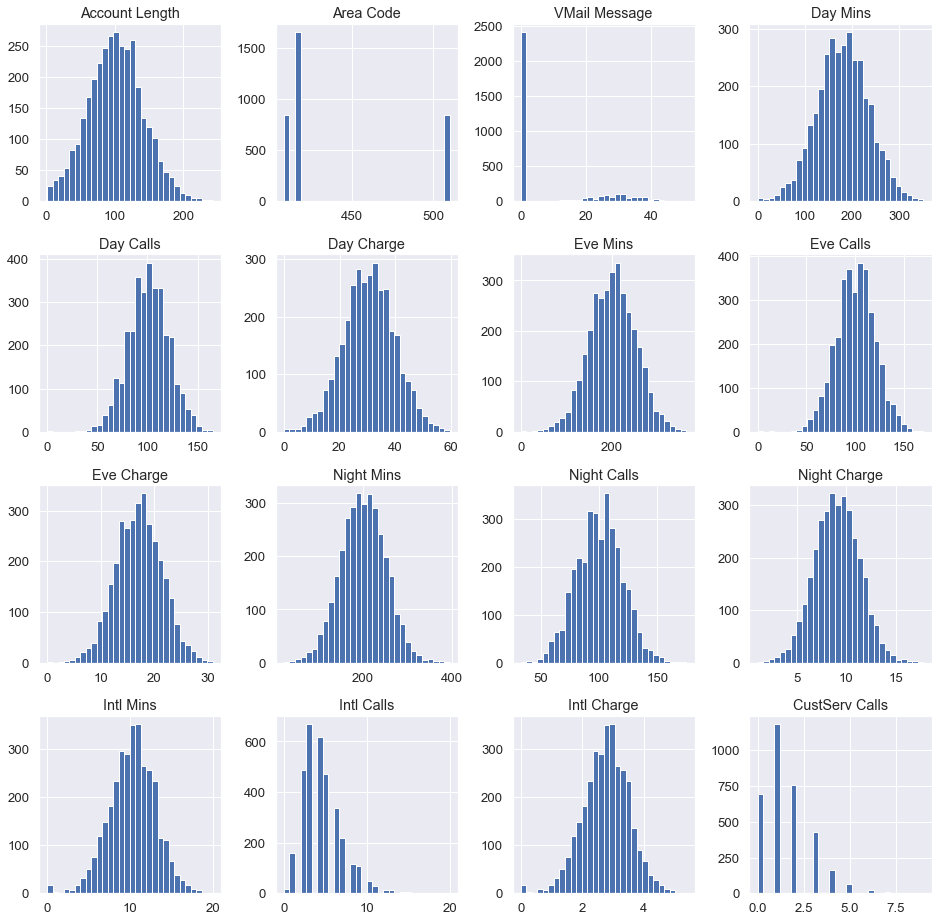

In [7]:
# show frequency tables for each categorical feature and counts of unique values
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column],
                        columns='% observations', 
                        normalize='columns').head(3))
    print("\n# of unique values = {:,}\n".format(churn[column].nunique()))
    print('#'*50)

# show summary statistics
display(churn.describe())

# build histograms for each numeric feature
%matplotlib inline
hist = churn.hist(bins=30, sharey=False, figsize=(16, 16))

We can see immediately that:
* `State` appears to be quite evenly distributed
* `Phone` takes on too many unique values to be of any practical use.  It's possible that parsing out the prefix could have some value, but unless you have more context on how these are allocated, avoid using it.
* Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
* Most of the numeric features are surprisingly well distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

### Exercise 1

Now that we've shown how to do the first part of the exercise, it's time for you to complete the second part by looking at how each feature relates to our target variable `Churn?`. 

You can accomplish this using the same pandas functions of `crosstab()`and`hist()`by entering the code in the cell below.


In [8]:
## the solution from AWS

for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column],
                            columns=churn['Churn?'],
                            normalize='columns').head())
        print('\n'+'#'*50)
        
        if column == "Int'l Plan":
            display(pd.crosstab(index=churn['Churn?'],
                                columns=churn[column],
                                normalize='columns').head())
            print('\n'+'#'*50)
            
            
        if column == "VMail Plan":
            display(pd.crosstab(index=churn['Churn?'],
                                columns=churn[column],
                                normalize='columns').head())
            print('\n'+'#'*50)

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634



##################################################


Churn?,False.,True.
Phone,,
327-1058,0.000351,0.00000
327-1319,0.000351,0.00000
327-3053,0.000351,0.00000
327-3587,0.000000,0.00207
327-3850,0.000351,0.00000



##################################################


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644



##################################################


Int'l Plan,no,yes
Churn?,,
False.,0.88505,0.575851
True.,0.11495,0.424149



##################################################


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631



##################################################


VMail Plan,no,yes
Churn?,,
False.,0.832849,0.913232
True.,0.167151,0.086768



##################################################


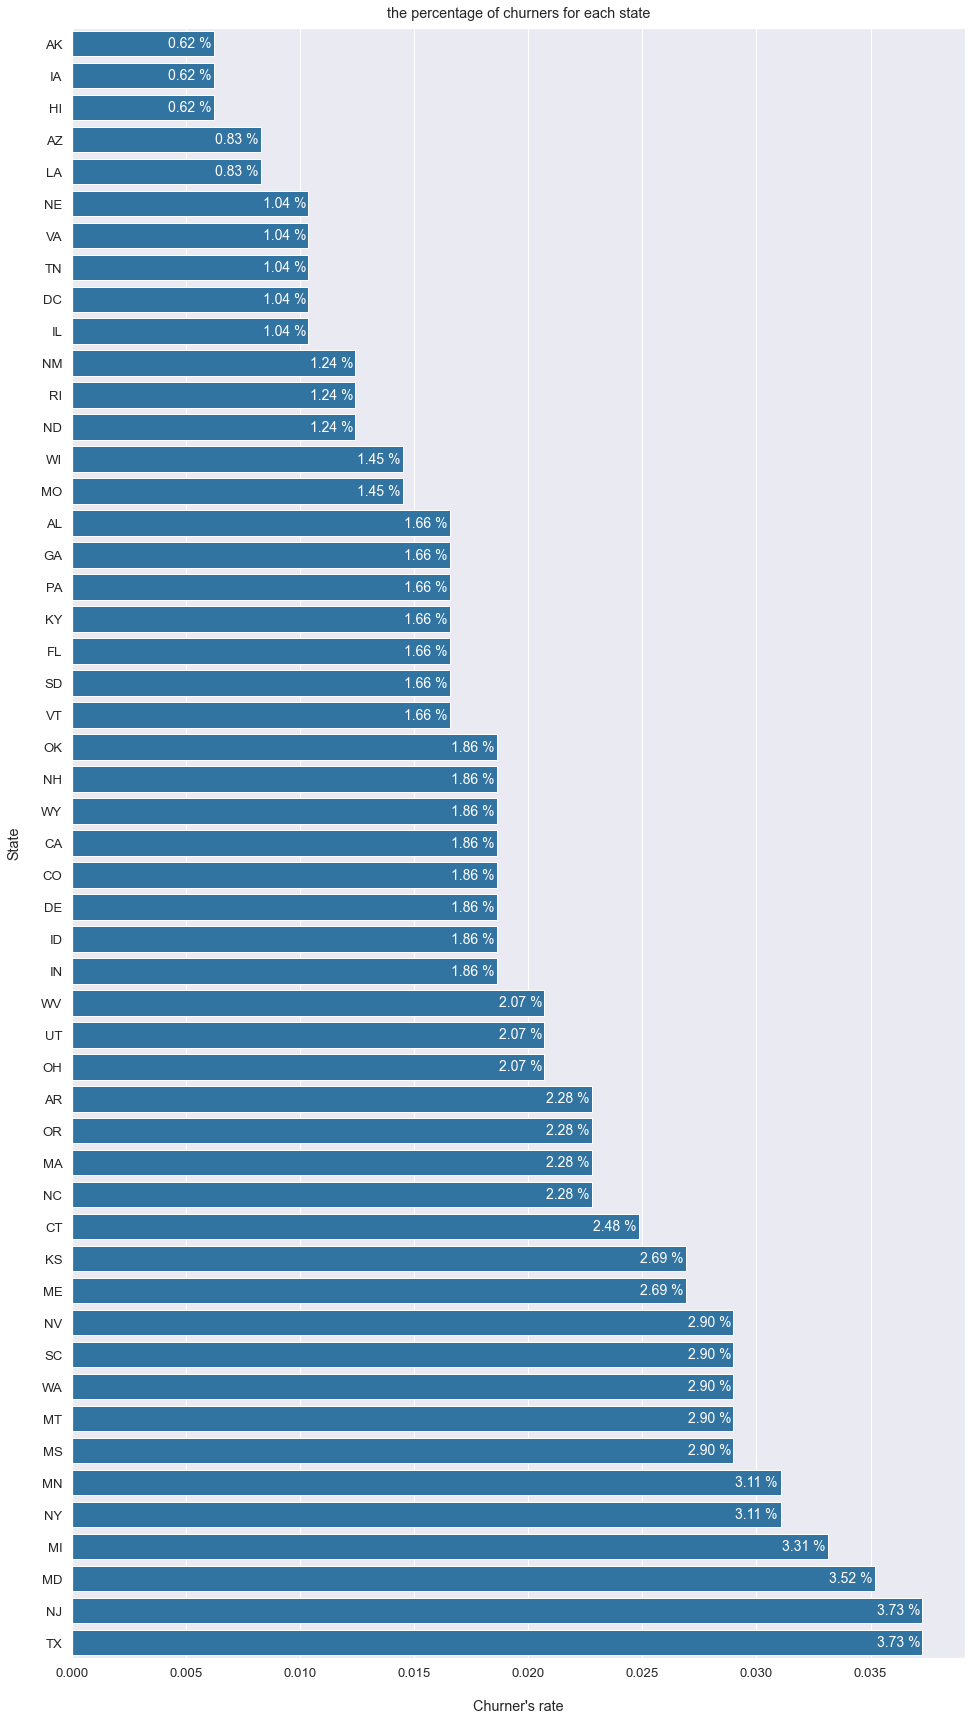

In [9]:
## generating the graph

## creating a dataframe for the states with the percentage of the churners
state_df = pd.crosstab(index=churn['State'],
                       columns=churn['Churn?'],
                       normalize='columns')

## setting the graph size
plt.figure(figsize=(16,30))

## plotting the graph
sns.barplot(y=state_df['True.'].sort_values().index, x=state_df['True.'].sort_values(), orient='h', color=base_color)

## adding the axes names and the graph title
plt.xlabel('Churner\'s rate', labelpad=20)
plt.ylabel('State', labelpad=20)
plt.title('the percentage of churners for each state', pad=10)

# ## adding the values to the graph bars
locs, labels = plt.yticks() # get the current tick locations and labels

for loc in locs:
    label = labels[loc]
    bar_value = state_df.loc[label.get_text()]['True.']
    bar_value_str = '{:.2f} %'.format(100*bar_value)
    plt.text(bar_value-0.002, loc, bar_value_str, va ='center', color ='w', fontdict={'size':14})

Account Length


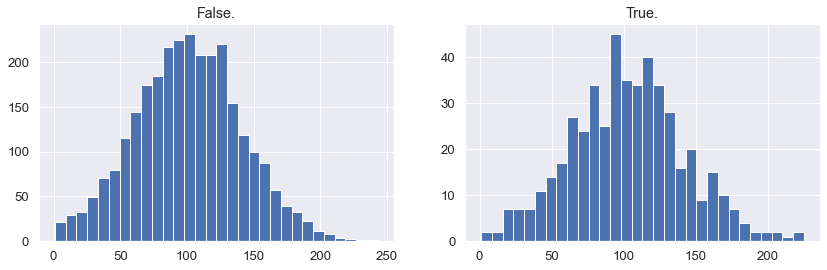

Area Code


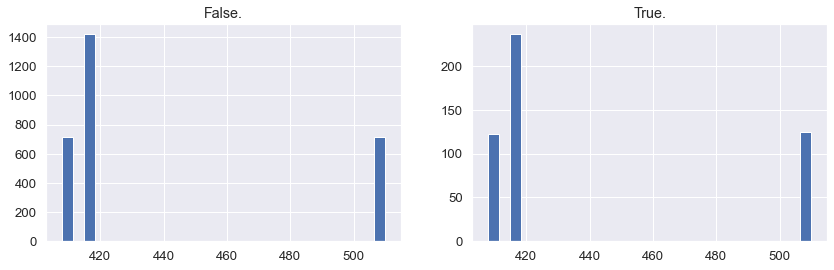

VMail Message


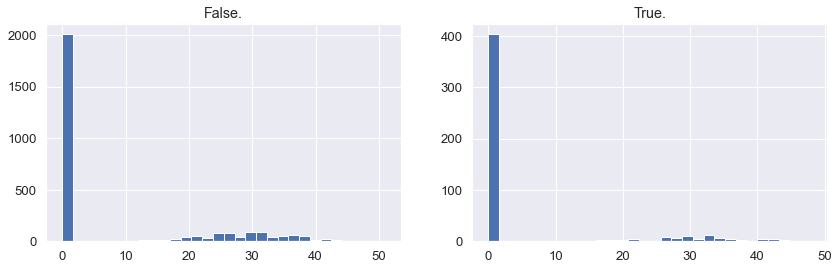

Day Mins


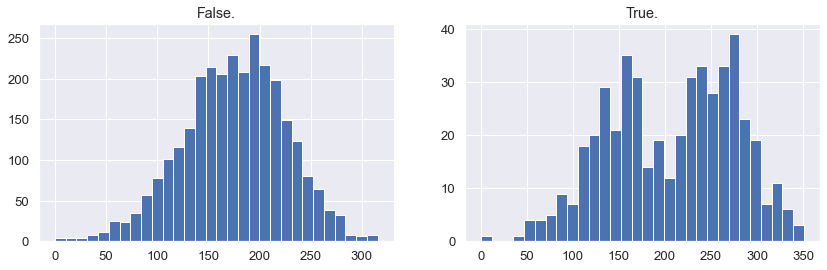

Day Calls


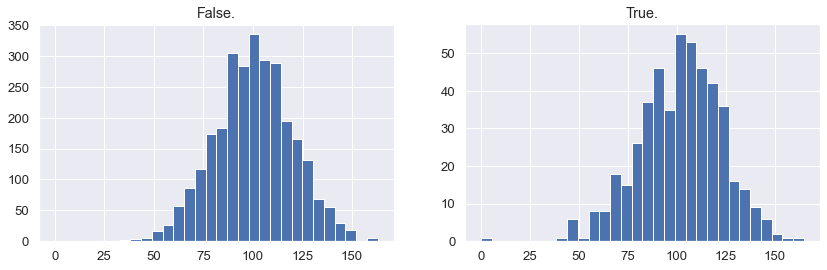

Day Charge


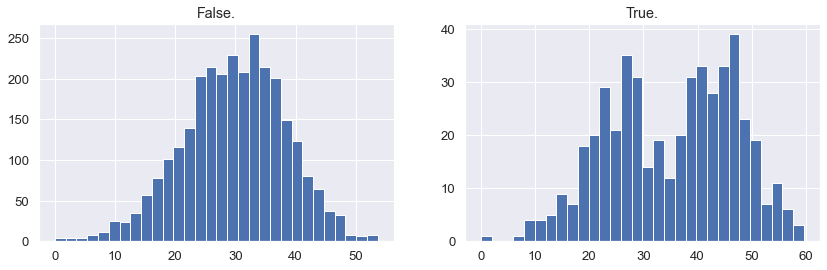

Eve Mins


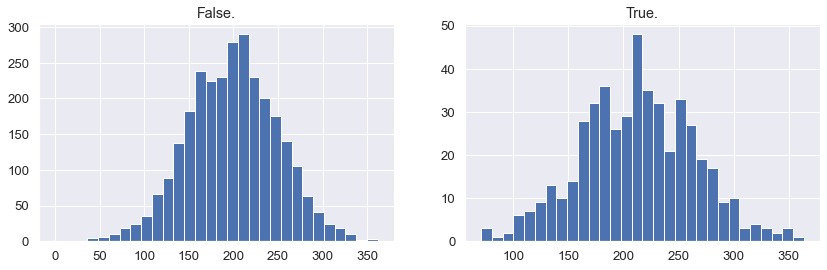

Eve Calls


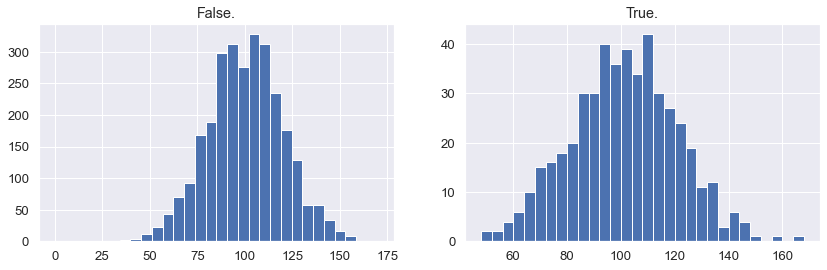

Eve Charge


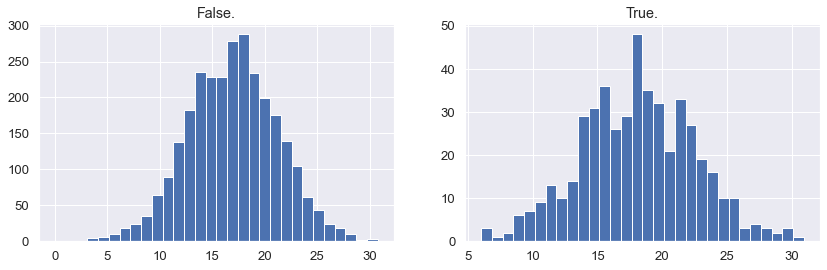

Night Mins


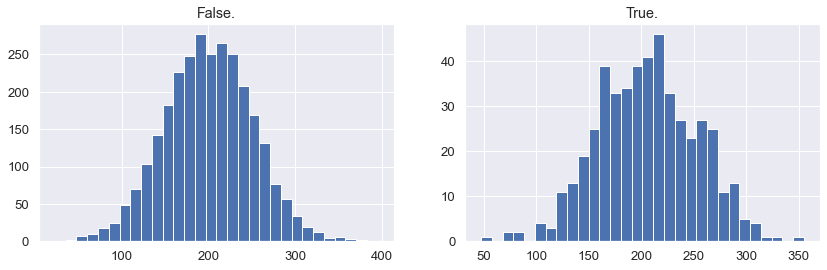

Night Calls


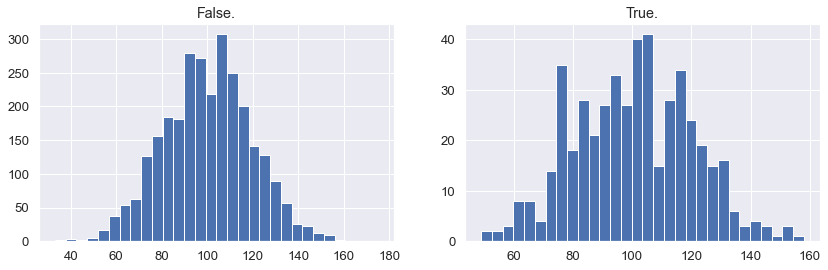

Night Charge


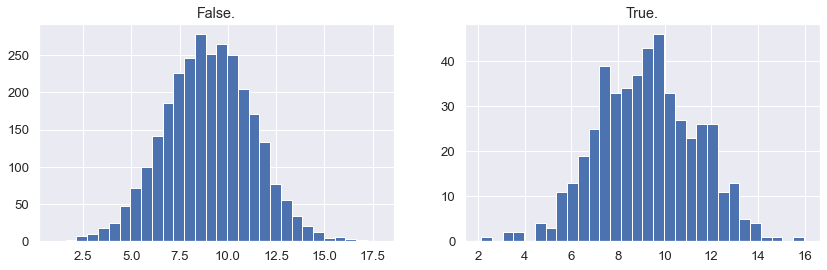

Intl Mins


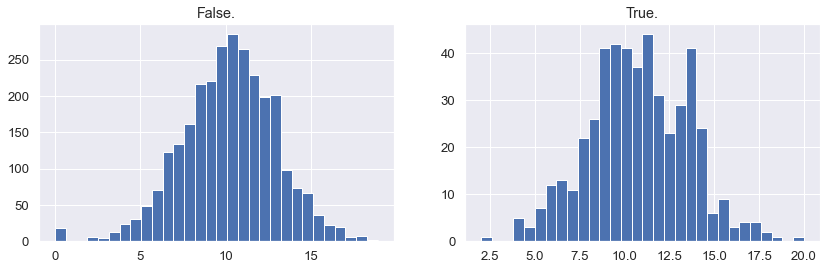

Intl Calls


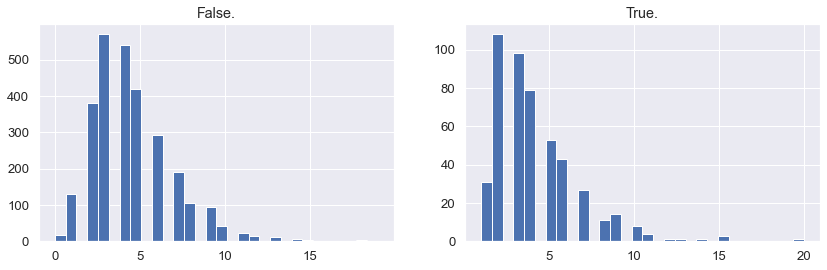

Intl Charge


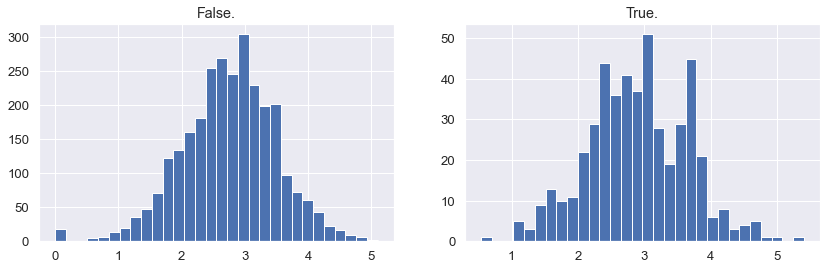

CustServ Calls


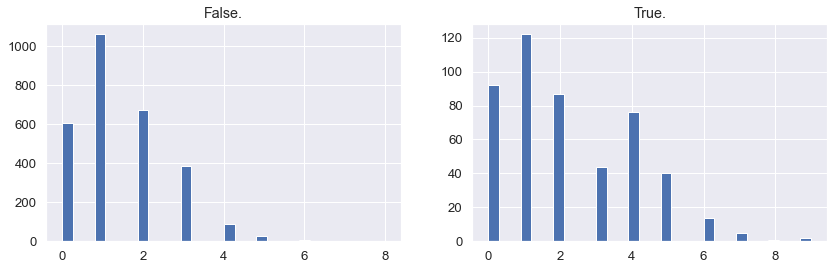

In [10]:
## generating clearer graphs

## first we create 2 dataframes, one of the churns and the other for the non-churns
is_churn = churn[churn['Churn?'] == 'True.']
not_churn = churn[churn['Churn?'] == 'False.']

## plotting the graphs
for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    axs[0].hist(not_churn[column], bins=30)
    axs[0].set_title('False.')
    axs[1].hist(is_churn[column], bins=30)
    axs[1].set_title('True.')
    plt.show()

Depending on your analysis, your solution might show different results, but you should see that churners appear:
* Fairly evenly distributed geographically
* More likely to have an international plan
* Less likely to have a voicemail plan
* Exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
* Larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

In addition, we see that churners take on very similar distributions for features like`Day Mins`and`Day Charge`.  

That's not surprising; you would expect minutes spent talking to correlate with charges.

### Exercise 2

Examine the pairwise relationships between attributes to see how they are correlated. Use the pandas functions [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) and [scatter_matrix()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html) pandas functions to achieve this. 

Enter your solution in the cell below. 

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.012463,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
Area Code,-0.012463,1.000000,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572
VMail Message,-0.004628,-0.001994,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,-0.008264,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009646,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,-0.008264,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.003580,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.011886,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.003607,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,-0.005825,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288


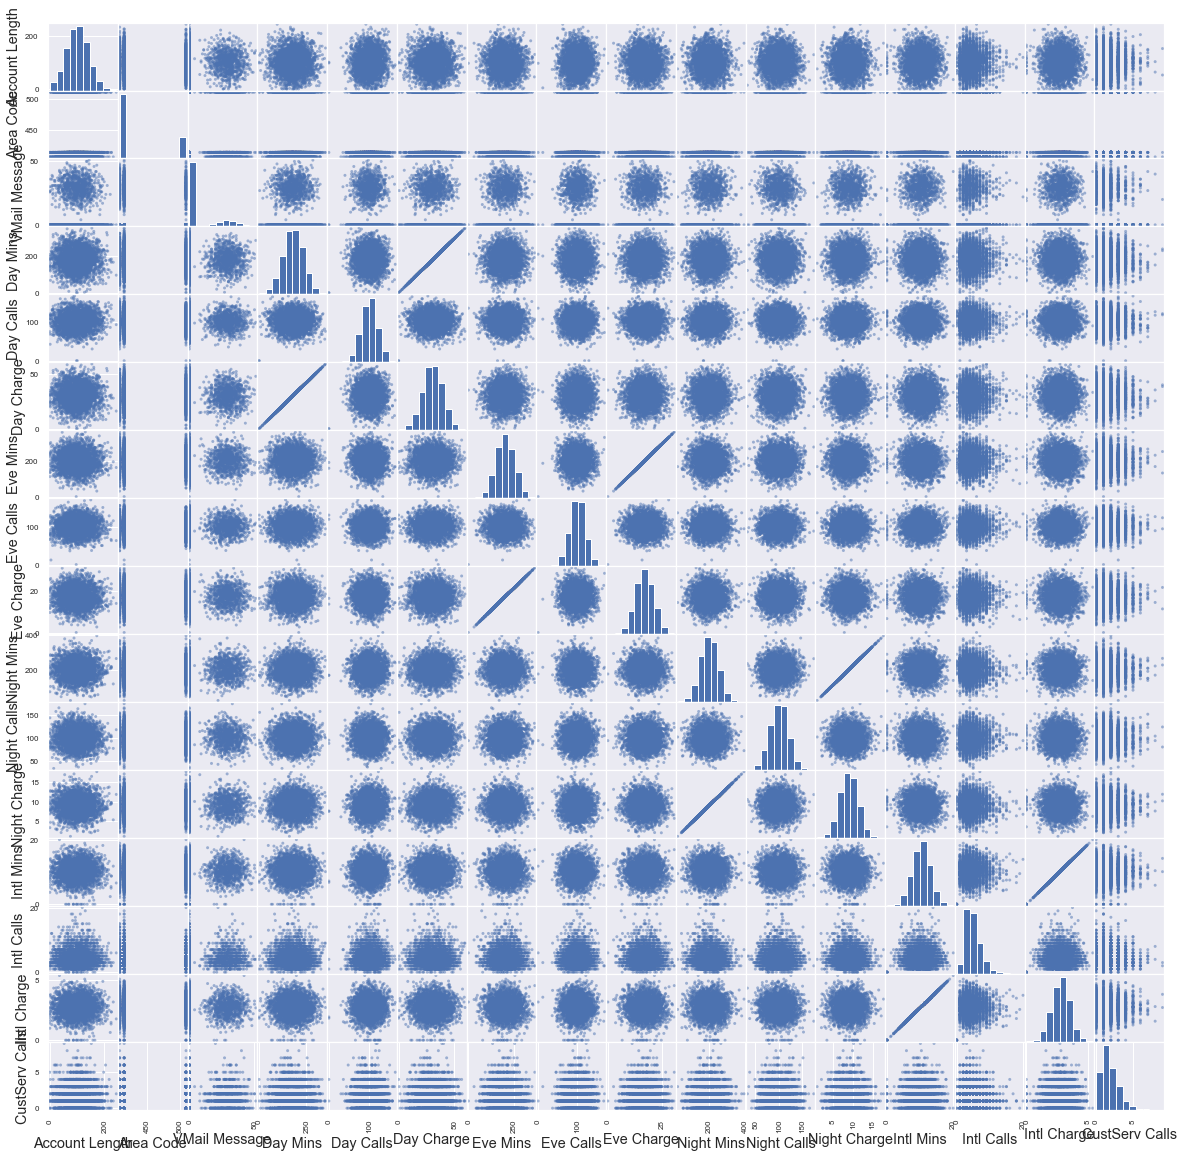

In [11]:
## Your solution goes here... 

display(churn.corr())

pd.plotting.scatter_matrix(churn, figsize=(20, 20))
plt.show()

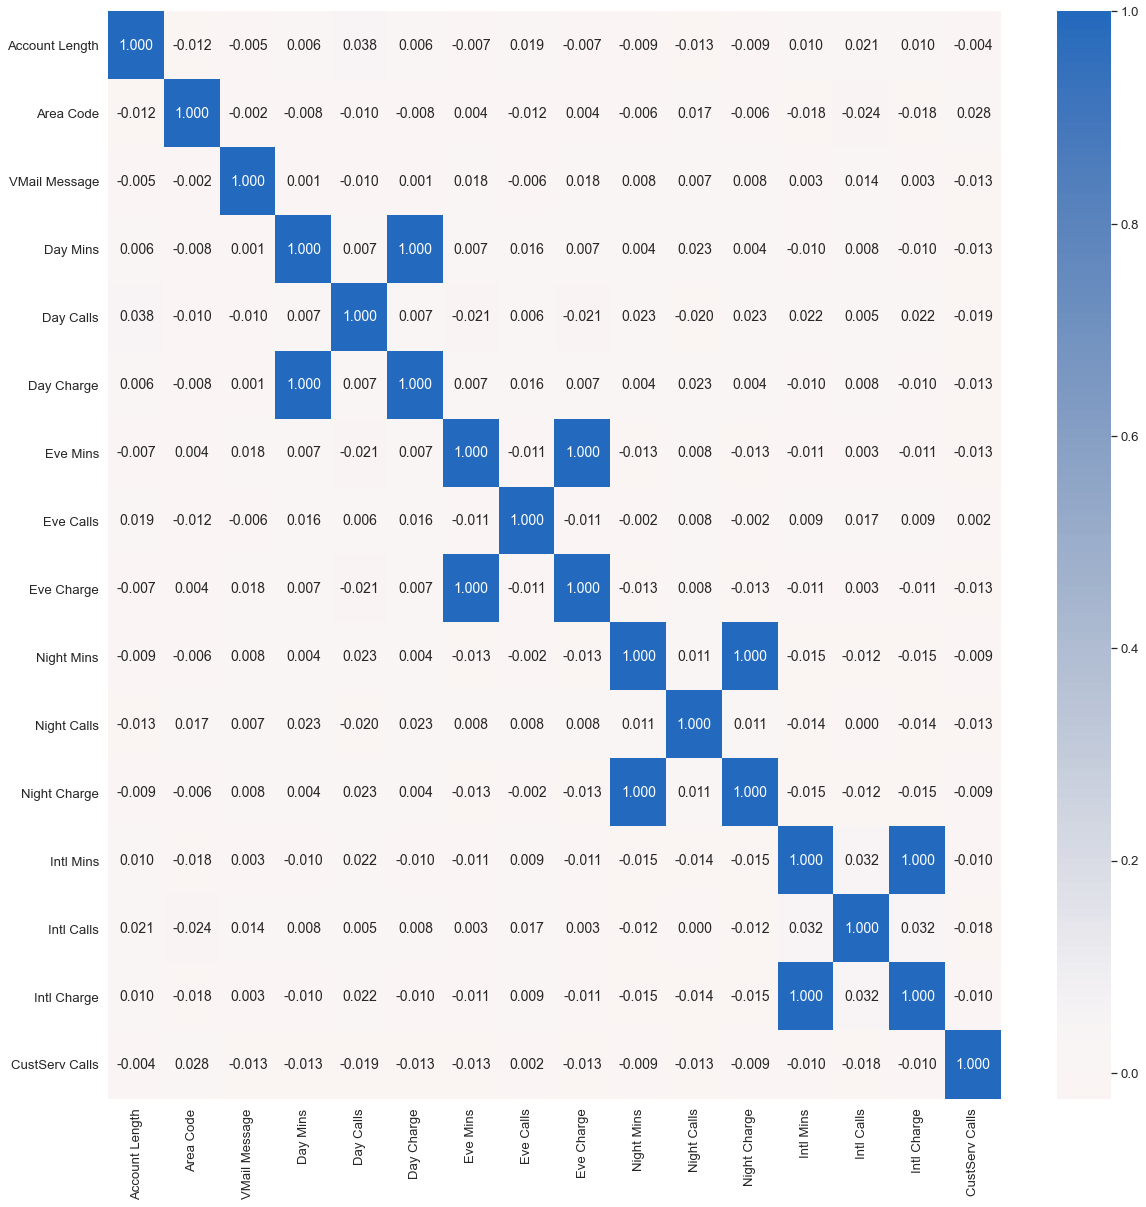

In [12]:
plt.figure(figsize=(20,20))
sns.heatmap(churn.corr(), annot=True, fmt='.3f', annot_kws={"size": 14}, cmap='vlag_r', center=0);

You should see several features that essentially have 100 percent correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.

In preparation for model training, first remove the columns that observed as useless for our purposes. 

Remove the`Phone`and`Area Code`attributes:

In [13]:
churn = churn.drop(['Phone', 'Area Code'], axis=1)

Next, remove one feature from each of the highly correlated pairs: 

* `Day Charge` from the pair with `Day Mins`
* `Night Charge` from the pair with `Night Mins`
* `Intl Charge` from the pair with `Intl Mins`

In [14]:
churn = churn.drop(['Day Charge', 'Eve Charge',
                    'Night Charge', 'Intl Charge'], axis=1)

Now that we have done all of the changes to the data, let's have a last look into how the data looks like before moving to training. 

In [15]:
churn.head()

,State,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,KS,128,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False.
1,OH,107,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False.
2,NJ,137,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False.
3,OH,84,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False.
4,OK,75,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False.


## Train and evaluate a model

Now, determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or *bucketed*) terms.  

Instead, let's attempt to model this problem using gradient boosted trees.  

Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees that naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
* Have the predictor variable in the first column
* Not have a header row

First, convert the categorical features into numeric features.

In [16]:
## creating a copy of the dataframe
df = churn.copy()

## dropping the state columns
df.drop(columns='State', inplace=True)

## checking the current dataframe
df.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,128,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False.
1,107,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False.
2,137,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False.
3,84,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False.
4,75,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False.


In [17]:
model1_data = pd.get_dummies(df)
model2_data = pd.get_dummies(churn)

display(model1_data.head(3))
print()
display(model2_data.head(3))

,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes,Churn?_False.,Churn?_True.
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,1,0,0,1,1,0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,1,0,0,1,1,0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,1,0,1,0,1,0


,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes,Churn?_False.,Churn?_True.
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [18]:
## dropping some columns and moving the target variable to be the first column
model1_data = pd.concat([model1_data['Churn?_True.'], model1_data.drop(
    ['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

model2_data = pd.concat([model2_data['Churn?_True.'], model2_data.drop(
    ['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

In [19]:
## displaying the first few rows of the data
display(model1_data.head(3))
print()
display(model2_data.head(3))

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,1,0,0,1
1,0,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,1,0,0,1
2,0,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,1,0,1,0


,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


Now split the data into training, validation, and test sets.  This will help prevent overfitting the model and allow you to test the model's accuracy on data it hasn't already seen.

In [20]:
## splitting the datasets into training, validation and test set
## starting with model's 2 dataset
train_data, validation_data, test_data = np.split(model2_data.sample(
    frac=1, random_state=1729), [int(0.7 * len(model2_data)), int(0.9 * len(model2_data))])
train_data.to_csv('train_m2.csv', header=True, index=False)
validation_data.to_csv('validation_m2.csv', header=True, index=False)
test_data.to_csv('test_m2.csv', header=True, index=False)

In [21]:
## now let's split the data for model's 1 dataset
train_data, validation_data, test_data = np.split(model1_data.sample(
    frac=1, random_state=1729), [int(0.7 * len(model1_data)), int(0.9 * len(model1_data))])
train_data.to_csv('train_m1.csv', header=True, index=False)
validation_data.to_csv('validation_m1.csv', header=True, index=False)
test_data.to_csv('test_m1.csv', header=True, index=False)

## Building a neural network with PyTorch

In [22]:
## import the required libraries
import torch
from torch import nn, optim
import torch.nn.functional as F

### Preparing the data

In [23]:
## loading the data from the saved csv files
train_data = pd.read_csv('train_m1.csv')
validation_data = pd.read_csv('validation_m1.csv')
test_data = pd.read_csv('test_m1.csv')

In [24]:
## dropping some redundant columns
train_data.drop(columns=["Int'l Plan_no", "VMail Plan_no"], inplace=True)
validation_data.drop(columns=["Int'l Plan_no", "VMail Plan_no"], inplace=True)
test_data.drop(columns=["Int'l Plan_no", "VMail Plan_no"], inplace=True)

### Building the data scaling function

In [25]:
## importing the required library to scale the features
from sklearn.preprocessing import StandardScaler

## creating a scaler for the numeric columns needed to be scaled
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(train_data.values[:, 1:12])

### Scaling the data and Putting it in the proper format for PyTorch

In [26]:
## training data
train_data = train_data.values
train_data[:, 1:12] = feature_scaler.transform(train_data[:, 1:12])
inputs = torch.tensor(train_data[:, 1:]).float()
labels = torch.tensor(train_data[:, 0]).long()

## validation data
validation_data = validation_data.values
validation_data[:, 1:12] = feature_scaler.transform(validation_data[:, 1:12])
val_inputs = torch.tensor(validation_data[:, 1:]).float()
val_labels = torch.tensor(validation_data[:, 0]).long()

## testing data
test_data = test_data.values
test_data[:, 1:12] = feature_scaler.transform(test_data[:, 1:12])
test_inputs = torch.tensor(test_data[:, 1:]).float()
test_labels = torch.tensor(test_data[:, 0]).long()

### Building the network

In [27]:
class Classifier1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(inputs.shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)
        self.drop = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [28]:
## create an instance of the network
model1 = Classifier1()

## moving the model to the GPU
model1.cuda()

## initiating the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001)

### Training the network

In [29]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model1.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model1(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model1.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model1(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model1.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 50:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint1.pth')

epoch =>    100 	 the training loss = 0.778 	 the validation loss = 0.774
epoch =>    200 	 the training loss = 0.726 	 the validation loss = 0.726
epoch =>    300 	 the training loss = 0.682 	 the validation loss = 0.685
epoch =>    400 	 the training loss = 0.647 	 the validation loss = 0.650
epoch =>    500 	 the training loss = 0.615 	 the validation loss = 0.621
epoch =>    600 	 the training loss = 0.587 	 the validation loss = 0.596
epoch =>    700 	 the training loss = 0.563 	 the validation loss = 0.574
epoch =>    800 	 the training loss = 0.543 	 the validation loss = 0.556
epoch =>    900 	 the training loss = 0.525 	 the validation loss = 0.540
epoch =>  1,000 	 the training loss = 0.509 	 the validation loss = 0.527
epoch =>  1,100 	 the training loss = 0.497 	 the validation loss = 0.516
epoch =>  1,200 	 the training loss = 0.487 	 the validation loss = 0.506
epoch =>  1,300 	 the training loss = 0.476 	 the validation loss = 0.498
epoch =>  1,400 	 the training loss = 

epoch =>  4,900 	 the training loss = 0.413 	 the validation loss = 0.450
epoch =>  5,000 	 the training loss = 0.410 	 the validation loss = 0.450
epoch =>  5,100 	 the training loss = 0.413 	 the validation loss = 0.449
epoch =>  5,200 	 the training loss = 0.410 	 the validation loss = 0.449
epoch =>  5,300 	 the training loss = 0.412 	 the validation loss = 0.449
epoch =>  5,400 	 the training loss = 0.411 	 the validation loss = 0.449
epoch =>  5,500 	 the training loss = 0.411 	 the validation loss = 0.448
epoch =>  5,600 	 the training loss = 0.411 	 the validation loss = 0.448
epoch =>  5,700 	 the training loss = 0.411 	 the validation loss = 0.448
epoch =>  5,800 	 the training loss = 0.412 	 the validation loss = 0.448
epoch =>  5,900 	 the training loss = 0.410 	 the validation loss = 0.447
epoch =>  6,000 	 the training loss = 0.406 	 the validation loss = 0.447
epoch =>  6,100 	 the training loss = 0.406 	 the validation loss = 0.447
epoch =>  6,200 	 the training loss = 

epoch =>  9,600 	 the training loss = 0.395 	 the validation loss = 0.438
epoch =>  9,700 	 the training loss = 0.398 	 the validation loss = 0.438
epoch =>  9,800 	 the training loss = 0.397 	 the validation loss = 0.438
epoch =>  9,900 	 the training loss = 0.401 	 the validation loss = 0.437
epoch => 10,000 	 the training loss = 0.398 	 the validation loss = 0.437
epoch => 10,100 	 the training loss = 0.400 	 the validation loss = 0.437
epoch => 10,200 	 the training loss = 0.401 	 the validation loss = 0.437
epoch => 10,300 	 the training loss = 0.397 	 the validation loss = 0.437
epoch => 10,400 	 the training loss = 0.397 	 the validation loss = 0.436
epoch => 10,500 	 the training loss = 0.401 	 the validation loss = 0.436
epoch => 10,600 	 the training loss = 0.394 	 the validation loss = 0.436
epoch => 10,700 	 the training loss = 0.396 	 the validation loss = 0.436
epoch => 10,800 	 the training loss = 0.399 	 the validation loss = 0.435
epoch => 10,900 	 the training loss = 

epoch => 14,300 	 the training loss = 0.387 	 the validation loss = 0.427
epoch => 14,400 	 the training loss = 0.387 	 the validation loss = 0.427
epoch => 14,500 	 the training loss = 0.391 	 the validation loss = 0.426
epoch => 14,600 	 the training loss = 0.387 	 the validation loss = 0.426
epoch => 14,700 	 the training loss = 0.389 	 the validation loss = 0.426
epoch => 14,800 	 the training loss = 0.389 	 the validation loss = 0.426
epoch => 14,900 	 the training loss = 0.388 	 the validation loss = 0.425
epoch => 15,000 	 the training loss = 0.389 	 the validation loss = 0.425
epoch => 15,100 	 the training loss = 0.388 	 the validation loss = 0.425
epoch => 15,200 	 the training loss = 0.388 	 the validation loss = 0.425
epoch => 15,300 	 the training loss = 0.386 	 the validation loss = 0.424
epoch => 15,400 	 the training loss = 0.385 	 the validation loss = 0.424
epoch => 15,500 	 the training loss = 0.388 	 the validation loss = 0.424
epoch => 15,600 	 the training loss = 

epoch => 19,100 	 the training loss = 0.379 	 the validation loss = 0.414
epoch => 19,200 	 the training loss = 0.380 	 the validation loss = 0.414
epoch => 19,300 	 the training loss = 0.380 	 the validation loss = 0.414
epoch => 19,400 	 the training loss = 0.378 	 the validation loss = 0.413
epoch => 19,500 	 the training loss = 0.377 	 the validation loss = 0.413
epoch => 19,600 	 the training loss = 0.376 	 the validation loss = 0.413
epoch => 19,700 	 the training loss = 0.377 	 the validation loss = 0.412
epoch => 19,800 	 the training loss = 0.376 	 the validation loss = 0.412
epoch => 19,900 	 the training loss = 0.376 	 the validation loss = 0.412
epoch => 20,000 	 the training loss = 0.376 	 the validation loss = 0.412
epoch => 20,100 	 the training loss = 0.378 	 the validation loss = 0.411
epoch => 20,200 	 the training loss = 0.375 	 the validation loss = 0.411
epoch => 20,300 	 the training loss = 0.378 	 the validation loss = 0.411
epoch => 20,400 	 the training loss = 

epoch => 23,900 	 the training loss = 0.370 	 the validation loss = 0.401
epoch => 24,000 	 the training loss = 0.367 	 the validation loss = 0.401
epoch => 24,100 	 the training loss = 0.367 	 the validation loss = 0.400
epoch => 24,200 	 the training loss = 0.368 	 the validation loss = 0.400
epoch => 24,300 	 the training loss = 0.368 	 the validation loss = 0.400
epoch => 24,400 	 the training loss = 0.363 	 the validation loss = 0.400
epoch => 24,500 	 the training loss = 0.367 	 the validation loss = 0.399
epoch => 24,600 	 the training loss = 0.365 	 the validation loss = 0.399
epoch => 24,700 	 the training loss = 0.365 	 the validation loss = 0.399
epoch => 24,800 	 the training loss = 0.362 	 the validation loss = 0.398
epoch => 24,900 	 the training loss = 0.362 	 the validation loss = 0.398
epoch => 25,000 	 the training loss = 0.362 	 the validation loss = 0.398
epoch => 25,100 	 the training loss = 0.369 	 the validation loss = 0.398
epoch => 25,200 	 the training loss = 

epoch => 28,700 	 the training loss = 0.355 	 the validation loss = 0.389
epoch => 28,800 	 the training loss = 0.353 	 the validation loss = 0.388
epoch => 28,900 	 the training loss = 0.355 	 the validation loss = 0.388
epoch => 29,000 	 the training loss = 0.358 	 the validation loss = 0.388
epoch => 29,100 	 the training loss = 0.353 	 the validation loss = 0.388
epoch => 29,200 	 the training loss = 0.352 	 the validation loss = 0.387
epoch => 29,300 	 the training loss = 0.354 	 the validation loss = 0.387
epoch => 29,400 	 the training loss = 0.359 	 the validation loss = 0.387
epoch => 29,500 	 the training loss = 0.359 	 the validation loss = 0.387
epoch => 29,600 	 the training loss = 0.352 	 the validation loss = 0.386
epoch => 29,700 	 the training loss = 0.358 	 the validation loss = 0.386
epoch => 29,800 	 the training loss = 0.356 	 the validation loss = 0.386
epoch => 29,900 	 the training loss = 0.351 	 the validation loss = 0.386
epoch => 30,000 	 the training loss = 

epoch => 33,400 	 the training loss = 0.346 	 the validation loss = 0.377
epoch => 33,500 	 the training loss = 0.345 	 the validation loss = 0.377
epoch => 33,600 	 the training loss = 0.342 	 the validation loss = 0.377
epoch => 33,700 	 the training loss = 0.350 	 the validation loss = 0.376
epoch => 33,800 	 the training loss = 0.347 	 the validation loss = 0.376
epoch => 33,900 	 the training loss = 0.348 	 the validation loss = 0.376
epoch => 34,000 	 the training loss = 0.340 	 the validation loss = 0.376
epoch => 34,100 	 the training loss = 0.346 	 the validation loss = 0.376
epoch => 34,200 	 the training loss = 0.344 	 the validation loss = 0.375
epoch => 34,300 	 the training loss = 0.344 	 the validation loss = 0.375
epoch => 34,400 	 the training loss = 0.343 	 the validation loss = 0.375
epoch => 34,500 	 the training loss = 0.346 	 the validation loss = 0.375
epoch => 34,600 	 the training loss = 0.343 	 the validation loss = 0.374
epoch => 34,700 	 the training loss = 

epoch => 38,100 	 the training loss = 0.332 	 the validation loss = 0.367
epoch => 38,200 	 the training loss = 0.333 	 the validation loss = 0.367
epoch => 38,300 	 the training loss = 0.330 	 the validation loss = 0.366
epoch => 38,400 	 the training loss = 0.336 	 the validation loss = 0.366
epoch => 38,500 	 the training loss = 0.333 	 the validation loss = 0.366
epoch => 38,600 	 the training loss = 0.334 	 the validation loss = 0.366
epoch => 38,700 	 the training loss = 0.341 	 the validation loss = 0.366
epoch => 38,800 	 the training loss = 0.336 	 the validation loss = 0.365
epoch => 38,900 	 the training loss = 0.332 	 the validation loss = 0.365
epoch => 39,000 	 the training loss = 0.336 	 the validation loss = 0.365
epoch => 39,100 	 the training loss = 0.335 	 the validation loss = 0.365
epoch => 39,200 	 the training loss = 0.333 	 the validation loss = 0.365
epoch => 39,300 	 the training loss = 0.328 	 the validation loss = 0.364
epoch => 39,400 	 the training loss = 

epoch => 42,800 	 the training loss = 0.324 	 the validation loss = 0.357
epoch => 42,900 	 the training loss = 0.328 	 the validation loss = 0.357
epoch => 43,000 	 the training loss = 0.326 	 the validation loss = 0.357
epoch => 43,100 	 the training loss = 0.328 	 the validation loss = 0.357
epoch => 43,200 	 the training loss = 0.329 	 the validation loss = 0.356
epoch => 43,300 	 the training loss = 0.326 	 the validation loss = 0.356
epoch => 43,400 	 the training loss = 0.322 	 the validation loss = 0.356
epoch => 43,500 	 the training loss = 0.330 	 the validation loss = 0.356
epoch => 43,600 	 the training loss = 0.327 	 the validation loss = 0.356
epoch => 43,700 	 the training loss = 0.323 	 the validation loss = 0.355
epoch => 43,800 	 the training loss = 0.318 	 the validation loss = 0.355
epoch => 43,900 	 the training loss = 0.320 	 the validation loss = 0.355
epoch => 44,000 	 the training loss = 0.328 	 the validation loss = 0.355
epoch => 44,100 	 the training loss = 

epoch => 47,600 	 the training loss = 0.308 	 the validation loss = 0.348
epoch => 47,700 	 the training loss = 0.312 	 the validation loss = 0.348
epoch => 47,800 	 the training loss = 0.319 	 the validation loss = 0.348
epoch => 47,900 	 the training loss = 0.315 	 the validation loss = 0.348
epoch => 48,000 	 the training loss = 0.308 	 the validation loss = 0.348
epoch => 48,100 	 the training loss = 0.308 	 the validation loss = 0.347
epoch => 48,200 	 the training loss = 0.305 	 the validation loss = 0.347
epoch => 48,300 	 the training loss = 0.314 	 the validation loss = 0.347
epoch => 48,400 	 the training loss = 0.315 	 the validation loss = 0.347
epoch => 48,500 	 the training loss = 0.306 	 the validation loss = 0.347
epoch => 48,600 	 the training loss = 0.308 	 the validation loss = 0.347
epoch => 48,700 	 the training loss = 0.314 	 the validation loss = 0.346
epoch => 48,800 	 the training loss = 0.307 	 the validation loss = 0.346
epoch => 48,900 	 the training loss = 

epoch => 52,300 	 the training loss = 0.298 	 the validation loss = 0.341
epoch => 52,400 	 the training loss = 0.304 	 the validation loss = 0.341
epoch => 52,500 	 the training loss = 0.295 	 the validation loss = 0.341
epoch => 52,600 	 the training loss = 0.305 	 the validation loss = 0.341
epoch => 52,700 	 the training loss = 0.305 	 the validation loss = 0.340
epoch => 52,800 	 the training loss = 0.314 	 the validation loss = 0.340
epoch => 52,900 	 the training loss = 0.297 	 the validation loss = 0.340
epoch => 53,000 	 the training loss = 0.301 	 the validation loss = 0.340
epoch => 53,100 	 the training loss = 0.300 	 the validation loss = 0.340
epoch => 53,200 	 the training loss = 0.288 	 the validation loss = 0.340
epoch => 53,300 	 the training loss = 0.300 	 the validation loss = 0.340
epoch => 53,400 	 the training loss = 0.299 	 the validation loss = 0.339
epoch => 53,500 	 the training loss = 0.305 	 the validation loss = 0.339
epoch => 53,600 	 the training loss = 

epoch => 57,100 	 the training loss = 0.285 	 the validation loss = 0.335
epoch => 57,200 	 the training loss = 0.286 	 the validation loss = 0.335
epoch => 57,300 	 the training loss = 0.289 	 the validation loss = 0.335
epoch => 57,400 	 the training loss = 0.289 	 the validation loss = 0.335
epoch => 57,500 	 the training loss = 0.292 	 the validation loss = 0.334
epoch => 57,600 	 the training loss = 0.287 	 the validation loss = 0.334
epoch => 57,700 	 the training loss = 0.291 	 the validation loss = 0.334
epoch => 57,800 	 the training loss = 0.293 	 the validation loss = 0.334
epoch => 57,900 	 the training loss = 0.301 	 the validation loss = 0.334
epoch => 58,000 	 the training loss = 0.280 	 the validation loss = 0.334
epoch => 58,100 	 the training loss = 0.291 	 the validation loss = 0.334
epoch => 58,200 	 the training loss = 0.292 	 the validation loss = 0.334
epoch => 58,300 	 the training loss = 0.296 	 the validation loss = 0.334
epoch => 58,400 	 the training loss = 

epoch => 61,900 	 the training loss = 0.271 	 the validation loss = 0.330
epoch => 62,000 	 the training loss = 0.287 	 the validation loss = 0.330
epoch => 62,100 	 the training loss = 0.279 	 the validation loss = 0.330
epoch => 62,200 	 the training loss = 0.280 	 the validation loss = 0.330
epoch => 62,300 	 the training loss = 0.277 	 the validation loss = 0.330
epoch => 62,400 	 the training loss = 0.279 	 the validation loss = 0.330
epoch => 62,500 	 the training loss = 0.273 	 the validation loss = 0.330
epoch => 62,600 	 the training loss = 0.277 	 the validation loss = 0.330
epoch => 62,700 	 the training loss = 0.284 	 the validation loss = 0.329
epoch => 62,800 	 the training loss = 0.279 	 the validation loss = 0.329
epoch => 62,900 	 the training loss = 0.283 	 the validation loss = 0.329
epoch => 63,000 	 the training loss = 0.278 	 the validation loss = 0.329
epoch => 63,100 	 the training loss = 0.286 	 the validation loss = 0.329
epoch => 63,200 	 the training loss = 

epoch => 66,700 	 the training loss = 0.270 	 the validation loss = 0.326
epoch => 66,800 	 the training loss = 0.271 	 the validation loss = 0.326
epoch => 66,900 	 the training loss = 0.276 	 the validation loss = 0.326
epoch => 67,000 	 the training loss = 0.267 	 the validation loss = 0.326
epoch => 67,100 	 the training loss = 0.266 	 the validation loss = 0.326
epoch => 67,200 	 the training loss = 0.279 	 the validation loss = 0.326
epoch => 67,300 	 the training loss = 0.257 	 the validation loss = 0.326
epoch => 67,400 	 the training loss = 0.269 	 the validation loss = 0.326
epoch => 67,500 	 the training loss = 0.276 	 the validation loss = 0.326
epoch => 67,600 	 the training loss = 0.277 	 the validation loss = 0.326
epoch => 67,700 	 the training loss = 0.272 	 the validation loss = 0.326
epoch => 67,800 	 the training loss = 0.276 	 the validation loss = 0.326
epoch => 67,900 	 the training loss = 0.273 	 the validation loss = 0.326
epoch => 68,000 	 the training loss = 

epoch => 71,400 	 the training loss = 0.268 	 the validation loss = 0.324
epoch => 71,500 	 the training loss = 0.267 	 the validation loss = 0.324
epoch => 71,600 	 the training loss = 0.269 	 the validation loss = 0.324
epoch => 71,700 	 the training loss = 0.261 	 the validation loss = 0.324
epoch => 71,800 	 the training loss = 0.261 	 the validation loss = 0.323
epoch => 71,900 	 the training loss = 0.274 	 the validation loss = 0.323
epoch => 72,000 	 the training loss = 0.266 	 the validation loss = 0.323
epoch => 72,100 	 the training loss = 0.269 	 the validation loss = 0.323
epoch => 72,200 	 the training loss = 0.258 	 the validation loss = 0.323
epoch => 72,300 	 the training loss = 0.269 	 the validation loss = 0.323
epoch => 72,400 	 the training loss = 0.266 	 the validation loss = 0.323
epoch => 72,500 	 the training loss = 0.263 	 the validation loss = 0.323
epoch => 72,600 	 the training loss = 0.267 	 the validation loss = 0.323
epoch => 72,700 	 the training loss = 

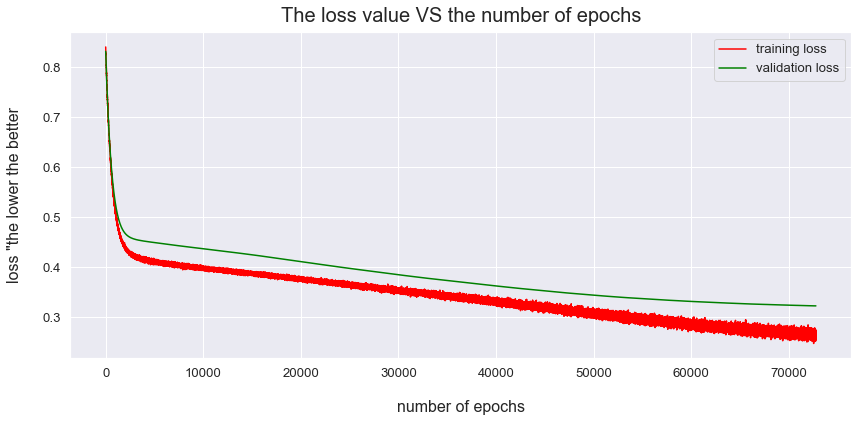

In [30]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [31]:
## loading the model with the best parameters
model1.load_state_dict(torch.load('checkpoint1.pth'))

<All keys matched successfully>

### Doing the inference

In [32]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model1.eval()

## moving the model back to the CPU
model1.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model1(test_inputs)

    ## calculating the test loss
    test_loss = criterion(predicted_output, test_labels)
    
    ## getting the probabilities using softmax function
    output = torch.softmax(predicted_output, dim=1)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))
print('\n'+ '#'*100 + '\n')
print(f'The test loss = {test_loss:.3f}')

the confusion matrix is:


,0,1
0,282,4
1,30,18



####################################################################################################

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       286
           1       0.82      0.38      0.51        48

    accuracy                           0.90       334
   macro avg       0.86      0.68      0.73       334
weighted avg       0.89      0.90      0.88       334


####################################################################################################

The test loss = 0.239


### Checking a different model with the same architecture

In [34]:
class Classifier2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(inputs.shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)
        self.drop = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x


## create an instance of the network
model2 = Classifier2()

## moving the model to the GPU
model2.cuda()

## initiating the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001)

### Training the network

In [35]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model2.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model2(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model2.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model2(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model2.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 50:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint2.pth')

epoch =>    100 	 the training loss = 0.712 	 the validation loss = 0.708
epoch =>    200 	 the training loss = 0.669 	 the validation loss = 0.669
epoch =>    300 	 the training loss = 0.633 	 the validation loss = 0.635
epoch =>    400 	 the training loss = 0.602 	 the validation loss = 0.607
epoch =>    500 	 the training loss = 0.574 	 the validation loss = 0.583
epoch =>    600 	 the training loss = 0.551 	 the validation loss = 0.562
epoch =>    700 	 the training loss = 0.535 	 the validation loss = 0.545
epoch =>    800 	 the training loss = 0.516 	 the validation loss = 0.531
epoch =>    900 	 the training loss = 0.504 	 the validation loss = 0.519
epoch =>  1,000 	 the training loss = 0.488 	 the validation loss = 0.509
epoch =>  1,100 	 the training loss = 0.478 	 the validation loss = 0.501
epoch =>  1,200 	 the training loss = 0.473 	 the validation loss = 0.494
epoch =>  1,300 	 the training loss = 0.467 	 the validation loss = 0.488
epoch =>  1,400 	 the training loss = 

epoch =>  4,800 	 the training loss = 0.412 	 the validation loss = 0.449
epoch =>  4,900 	 the training loss = 0.403 	 the validation loss = 0.448
epoch =>  5,000 	 the training loss = 0.410 	 the validation loss = 0.448
epoch =>  5,100 	 the training loss = 0.413 	 the validation loss = 0.447
epoch =>  5,200 	 the training loss = 0.406 	 the validation loss = 0.447
epoch =>  5,300 	 the training loss = 0.414 	 the validation loss = 0.446
epoch =>  5,400 	 the training loss = 0.407 	 the validation loss = 0.446
epoch =>  5,500 	 the training loss = 0.413 	 the validation loss = 0.445
epoch =>  5,600 	 the training loss = 0.406 	 the validation loss = 0.445
epoch =>  5,700 	 the training loss = 0.405 	 the validation loss = 0.444
epoch =>  5,800 	 the training loss = 0.407 	 the validation loss = 0.444
epoch =>  5,900 	 the training loss = 0.412 	 the validation loss = 0.444
epoch =>  6,000 	 the training loss = 0.405 	 the validation loss = 0.443
epoch =>  6,100 	 the training loss = 

epoch =>  9,600 	 the training loss = 0.392 	 the validation loss = 0.428
epoch =>  9,700 	 the training loss = 0.394 	 the validation loss = 0.428
epoch =>  9,800 	 the training loss = 0.393 	 the validation loss = 0.427
epoch =>  9,900 	 the training loss = 0.392 	 the validation loss = 0.427
epoch => 10,000 	 the training loss = 0.391 	 the validation loss = 0.427
epoch => 10,100 	 the training loss = 0.392 	 the validation loss = 0.426
epoch => 10,200 	 the training loss = 0.389 	 the validation loss = 0.426
epoch => 10,300 	 the training loss = 0.396 	 the validation loss = 0.425
epoch => 10,400 	 the training loss = 0.390 	 the validation loss = 0.425
epoch => 10,500 	 the training loss = 0.397 	 the validation loss = 0.425
epoch => 10,600 	 the training loss = 0.387 	 the validation loss = 0.424
epoch => 10,700 	 the training loss = 0.389 	 the validation loss = 0.424
epoch => 10,800 	 the training loss = 0.393 	 the validation loss = 0.424
epoch => 10,900 	 the training loss = 

epoch => 14,300 	 the training loss = 0.380 	 the validation loss = 0.413
epoch => 14,400 	 the training loss = 0.383 	 the validation loss = 0.412
epoch => 14,500 	 the training loss = 0.381 	 the validation loss = 0.412
epoch => 14,600 	 the training loss = 0.378 	 the validation loss = 0.412
epoch => 14,700 	 the training loss = 0.379 	 the validation loss = 0.411
epoch => 14,800 	 the training loss = 0.381 	 the validation loss = 0.411
epoch => 14,900 	 the training loss = 0.380 	 the validation loss = 0.411
epoch => 15,000 	 the training loss = 0.379 	 the validation loss = 0.411
epoch => 15,100 	 the training loss = 0.381 	 the validation loss = 0.410
epoch => 15,200 	 the training loss = 0.381 	 the validation loss = 0.410
epoch => 15,300 	 the training loss = 0.380 	 the validation loss = 0.410
epoch => 15,400 	 the training loss = 0.381 	 the validation loss = 0.410
epoch => 15,500 	 the training loss = 0.374 	 the validation loss = 0.409
epoch => 15,600 	 the training loss = 

epoch => 19,000 	 the training loss = 0.370 	 the validation loss = 0.399
epoch => 19,100 	 the training loss = 0.370 	 the validation loss = 0.399
epoch => 19,200 	 the training loss = 0.372 	 the validation loss = 0.399
epoch => 19,300 	 the training loss = 0.368 	 the validation loss = 0.399
epoch => 19,400 	 the training loss = 0.372 	 the validation loss = 0.398
epoch => 19,500 	 the training loss = 0.374 	 the validation loss = 0.398
epoch => 19,600 	 the training loss = 0.372 	 the validation loss = 0.398
epoch => 19,700 	 the training loss = 0.372 	 the validation loss = 0.398
epoch => 19,800 	 the training loss = 0.371 	 the validation loss = 0.397
epoch => 19,900 	 the training loss = 0.366 	 the validation loss = 0.397
epoch => 20,000 	 the training loss = 0.368 	 the validation loss = 0.397
epoch => 20,100 	 the training loss = 0.366 	 the validation loss = 0.396
epoch => 20,200 	 the training loss = 0.366 	 the validation loss = 0.396
epoch => 20,300 	 the training loss = 

epoch => 23,700 	 the training loss = 0.362 	 the validation loss = 0.387
epoch => 23,800 	 the training loss = 0.364 	 the validation loss = 0.387
epoch => 23,900 	 the training loss = 0.366 	 the validation loss = 0.387
epoch => 24,000 	 the training loss = 0.358 	 the validation loss = 0.387
epoch => 24,100 	 the training loss = 0.360 	 the validation loss = 0.386
epoch => 24,200 	 the training loss = 0.358 	 the validation loss = 0.386
epoch => 24,300 	 the training loss = 0.358 	 the validation loss = 0.386
epoch => 24,400 	 the training loss = 0.358 	 the validation loss = 0.386
epoch => 24,500 	 the training loss = 0.361 	 the validation loss = 0.385
epoch => 24,600 	 the training loss = 0.354 	 the validation loss = 0.385
epoch => 24,700 	 the training loss = 0.358 	 the validation loss = 0.385
epoch => 24,800 	 the training loss = 0.361 	 the validation loss = 0.385
epoch => 24,900 	 the training loss = 0.360 	 the validation loss = 0.384
epoch => 25,000 	 the training loss = 

epoch => 28,400 	 the training loss = 0.345 	 the validation loss = 0.376
epoch => 28,500 	 the training loss = 0.351 	 the validation loss = 0.376
epoch => 28,600 	 the training loss = 0.349 	 the validation loss = 0.376
epoch => 28,700 	 the training loss = 0.347 	 the validation loss = 0.376
epoch => 28,800 	 the training loss = 0.349 	 the validation loss = 0.375
epoch => 28,900 	 the training loss = 0.349 	 the validation loss = 0.375
epoch => 29,000 	 the training loss = 0.349 	 the validation loss = 0.375
epoch => 29,100 	 the training loss = 0.348 	 the validation loss = 0.375
epoch => 29,200 	 the training loss = 0.347 	 the validation loss = 0.374
epoch => 29,300 	 the training loss = 0.350 	 the validation loss = 0.374
epoch => 29,400 	 the training loss = 0.347 	 the validation loss = 0.374
epoch => 29,500 	 the training loss = 0.344 	 the validation loss = 0.374
epoch => 29,600 	 the training loss = 0.349 	 the validation loss = 0.373
epoch => 29,700 	 the training loss = 

epoch => 33,100 	 the training loss = 0.338 	 the validation loss = 0.365
epoch => 33,200 	 the training loss = 0.344 	 the validation loss = 0.365
epoch => 33,300 	 the training loss = 0.342 	 the validation loss = 0.365
epoch => 33,400 	 the training loss = 0.341 	 the validation loss = 0.364
epoch => 33,500 	 the training loss = 0.336 	 the validation loss = 0.364
epoch => 33,600 	 the training loss = 0.340 	 the validation loss = 0.364
epoch => 33,700 	 the training loss = 0.336 	 the validation loss = 0.364
epoch => 33,800 	 the training loss = 0.342 	 the validation loss = 0.364
epoch => 33,900 	 the training loss = 0.335 	 the validation loss = 0.363
epoch => 34,000 	 the training loss = 0.336 	 the validation loss = 0.363
epoch => 34,100 	 the training loss = 0.343 	 the validation loss = 0.363
epoch => 34,200 	 the training loss = 0.337 	 the validation loss = 0.363
epoch => 34,300 	 the training loss = 0.334 	 the validation loss = 0.362
epoch => 34,400 	 the training loss = 

epoch => 37,800 	 the training loss = 0.325 	 the validation loss = 0.354
epoch => 37,900 	 the training loss = 0.327 	 the validation loss = 0.353
epoch => 38,000 	 the training loss = 0.331 	 the validation loss = 0.353
epoch => 38,100 	 the training loss = 0.331 	 the validation loss = 0.353
epoch => 38,200 	 the training loss = 0.324 	 the validation loss = 0.353
epoch => 38,300 	 the training loss = 0.329 	 the validation loss = 0.352
epoch => 38,400 	 the training loss = 0.330 	 the validation loss = 0.352
epoch => 38,500 	 the training loss = 0.332 	 the validation loss = 0.352
epoch => 38,600 	 the training loss = 0.326 	 the validation loss = 0.352
epoch => 38,700 	 the training loss = 0.328 	 the validation loss = 0.351
epoch => 38,800 	 the training loss = 0.323 	 the validation loss = 0.351
epoch => 38,900 	 the training loss = 0.324 	 the validation loss = 0.351
epoch => 39,000 	 the training loss = 0.325 	 the validation loss = 0.351
epoch => 39,100 	 the training loss = 

epoch => 42,500 	 the training loss = 0.314 	 the validation loss = 0.342
epoch => 42,600 	 the training loss = 0.306 	 the validation loss = 0.342
epoch => 42,700 	 the training loss = 0.312 	 the validation loss = 0.341
epoch => 42,800 	 the training loss = 0.311 	 the validation loss = 0.341
epoch => 42,900 	 the training loss = 0.324 	 the validation loss = 0.341
epoch => 43,000 	 the training loss = 0.311 	 the validation loss = 0.341
epoch => 43,100 	 the training loss = 0.313 	 the validation loss = 0.340
epoch => 43,200 	 the training loss = 0.312 	 the validation loss = 0.340
epoch => 43,300 	 the training loss = 0.320 	 the validation loss = 0.340
epoch => 43,400 	 the training loss = 0.309 	 the validation loss = 0.340
epoch => 43,500 	 the training loss = 0.314 	 the validation loss = 0.339
epoch => 43,600 	 the training loss = 0.313 	 the validation loss = 0.339
epoch => 43,700 	 the training loss = 0.317 	 the validation loss = 0.339
epoch => 43,800 	 the training loss = 

epoch => 47,200 	 the training loss = 0.298 	 the validation loss = 0.331
epoch => 47,300 	 the training loss = 0.302 	 the validation loss = 0.330
epoch => 47,400 	 the training loss = 0.299 	 the validation loss = 0.330
epoch => 47,500 	 the training loss = 0.303 	 the validation loss = 0.330
epoch => 47,600 	 the training loss = 0.304 	 the validation loss = 0.330
epoch => 47,700 	 the training loss = 0.300 	 the validation loss = 0.330
epoch => 47,800 	 the training loss = 0.296 	 the validation loss = 0.329
epoch => 47,900 	 the training loss = 0.296 	 the validation loss = 0.329
epoch => 48,000 	 the training loss = 0.298 	 the validation loss = 0.329
epoch => 48,100 	 the training loss = 0.300 	 the validation loss = 0.329
epoch => 48,200 	 the training loss = 0.300 	 the validation loss = 0.329
epoch => 48,300 	 the training loss = 0.300 	 the validation loss = 0.328
epoch => 48,400 	 the training loss = 0.307 	 the validation loss = 0.328
epoch => 48,500 	 the training loss = 

epoch => 51,900 	 the training loss = 0.279 	 the validation loss = 0.322
epoch => 52,000 	 the training loss = 0.287 	 the validation loss = 0.322
epoch => 52,100 	 the training loss = 0.289 	 the validation loss = 0.322
epoch => 52,200 	 the training loss = 0.292 	 the validation loss = 0.322
epoch => 52,300 	 the training loss = 0.282 	 the validation loss = 0.321
epoch => 52,400 	 the training loss = 0.290 	 the validation loss = 0.321
epoch => 52,500 	 the training loss = 0.283 	 the validation loss = 0.321
epoch => 52,600 	 the training loss = 0.291 	 the validation loss = 0.321
epoch => 52,700 	 the training loss = 0.282 	 the validation loss = 0.321
epoch => 52,800 	 the training loss = 0.297 	 the validation loss = 0.321
epoch => 52,900 	 the training loss = 0.287 	 the validation loss = 0.320
epoch => 53,000 	 the training loss = 0.292 	 the validation loss = 0.320
epoch => 53,100 	 the training loss = 0.284 	 the validation loss = 0.320
epoch => 53,200 	 the training loss = 

epoch => 56,600 	 the training loss = 0.278 	 the validation loss = 0.316
epoch => 56,700 	 the training loss = 0.263 	 the validation loss = 0.315
epoch => 56,800 	 the training loss = 0.281 	 the validation loss = 0.315
epoch => 56,900 	 the training loss = 0.272 	 the validation loss = 0.315
epoch => 57,000 	 the training loss = 0.272 	 the validation loss = 0.315
epoch => 57,100 	 the training loss = 0.286 	 the validation loss = 0.315
epoch => 57,200 	 the training loss = 0.275 	 the validation loss = 0.315
epoch => 57,300 	 the training loss = 0.279 	 the validation loss = 0.315
epoch => 57,400 	 the training loss = 0.278 	 the validation loss = 0.315
epoch => 57,500 	 the training loss = 0.272 	 the validation loss = 0.315
epoch => 57,600 	 the training loss = 0.279 	 the validation loss = 0.315
epoch => 57,700 	 the training loss = 0.274 	 the validation loss = 0.314
epoch => 57,800 	 the training loss = 0.276 	 the validation loss = 0.314
epoch => 57,900 	 the training loss = 

epoch => 61,300 	 the training loss = 0.274 	 the validation loss = 0.311
epoch => 61,400 	 the training loss = 0.274 	 the validation loss = 0.311
epoch => 61,500 	 the training loss = 0.272 	 the validation loss = 0.311
epoch => 61,600 	 the training loss = 0.275 	 the validation loss = 0.311
epoch => 61,700 	 the training loss = 0.271 	 the validation loss = 0.311
epoch => 61,800 	 the training loss = 0.276 	 the validation loss = 0.310
epoch => 61,900 	 the training loss = 0.271 	 the validation loss = 0.310
epoch => 62,000 	 the training loss = 0.269 	 the validation loss = 0.310
epoch => 62,100 	 the training loss = 0.269 	 the validation loss = 0.310
epoch => 62,200 	 the training loss = 0.266 	 the validation loss = 0.310
epoch => 62,300 	 the training loss = 0.269 	 the validation loss = 0.310
epoch => 62,400 	 the training loss = 0.267 	 the validation loss = 0.310
epoch => 62,500 	 the training loss = 0.276 	 the validation loss = 0.310
epoch => 62,600 	 the training loss = 

epoch => 66,000 	 the training loss = 0.264 	 the validation loss = 0.307
epoch => 66,100 	 the training loss = 0.260 	 the validation loss = 0.307
epoch => 66,200 	 the training loss = 0.259 	 the validation loss = 0.307
epoch => 66,300 	 the training loss = 0.256 	 the validation loss = 0.307
epoch => 66,400 	 the training loss = 0.274 	 the validation loss = 0.307
epoch => 66,500 	 the training loss = 0.273 	 the validation loss = 0.307
epoch => 66,600 	 the training loss = 0.269 	 the validation loss = 0.307
epoch => 66,700 	 the training loss = 0.255 	 the validation loss = 0.307

The model is no longer training so terminating the training process
####################################################################################################
The model has trained for 66,702 epochs in total
####################################################################################################
Wall time: 2min 25s


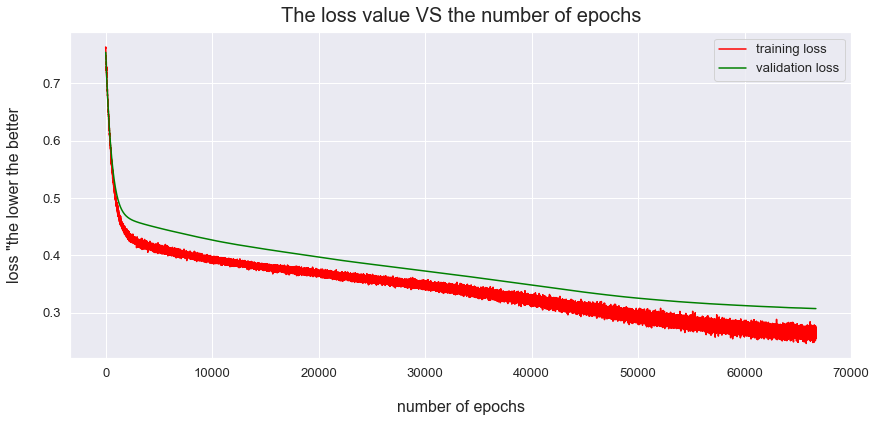

In [36]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [37]:
## loading the model with the best parameters
model2.load_state_dict(torch.load('checkpoint2.pth'))

<All keys matched successfully>

### Doing the inference

In [38]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model2.eval()

## moving the model back to the CPU
model2.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model2(test_inputs)

    ## calculating the test loss
    test_loss = criterion(predicted_output, test_labels)
    
    ## getting the probabilities using softmax function
    output = torch.exp(predicted_output)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [39]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))
print('\n'+ '#'*100 + '\n')
print(f'The test loss = {test_loss:.3f}')

the confusion matrix is:


,0,1
0,285,1
1,28,20



####################################################################################################

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       286
           1       0.95      0.42      0.58        48

    accuracy                           0.91       334
   macro avg       0.93      0.71      0.77       334
weighted avg       0.92      0.91      0.90       334


####################################################################################################

The test loss = 0.221


## from the cells above, we conclude the following

- the model is favoring predicting most of the inputs to belong to class 0
- the reason for the point above in the imbalanced dataset, as almost 14% of the dataset have the class = 1 while the remaining 86% of the records have the class = 0
- we will try now balancing the dataset by passing some weights to the criterion and then we will see the effect of such a step

In [40]:
print('The percent of class 1 records to the whole dataset = {:.2f} %'
      .format(100 * labels.cpu().numpy().mean()))
print('The percent of class 1 records to class 0 records = {:.2f} %'
      .format(100 * (labels.cpu().numpy() == 1).sum() / (labels.cpu().numpy() == 0).sum()))
print('The percent of class 1 records to class 0 records = {:.2f} %'
      .format(100 * (labels.cpu().numpy() == 0).sum() / (labels.cpu().numpy() == 1).sum()))

The percent of class 1 records to the whole dataset = 13.93 %
The percent of class 1 records to class 0 records = 16.19 %
The percent of class 1 records to class 0 records = 617.85 %


### Trying balancing the dataset

In [41]:
## create an instance of the network
model1 = Classifier1()

## moving the model to the GPU
model1.cuda()

## initiating the criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,6.2]).cuda())
optimizer = optim.SGD(model1.parameters(), lr=0.0005)

In [42]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model1.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model1(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model1.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model1(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model1.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 50:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint1.pth')

epoch =>    100 	 the training loss = 0.696 	 the validation loss = 0.687
epoch =>    200 	 the training loss = 0.694 	 the validation loss = 0.687
epoch =>    300 	 the training loss = 0.694 	 the validation loss = 0.687
epoch =>    400 	 the training loss = 0.693 	 the validation loss = 0.687
epoch =>    500 	 the training loss = 0.694 	 the validation loss = 0.686
epoch =>    600 	 the training loss = 0.691 	 the validation loss = 0.686
epoch =>    700 	 the training loss = 0.695 	 the validation loss = 0.686
epoch =>    800 	 the training loss = 0.692 	 the validation loss = 0.686
epoch =>    900 	 the training loss = 0.694 	 the validation loss = 0.686
epoch =>  1,000 	 the training loss = 0.693 	 the validation loss = 0.686
epoch =>  1,100 	 the training loss = 0.690 	 the validation loss = 0.686
epoch =>  1,200 	 the training loss = 0.692 	 the validation loss = 0.686
epoch =>  1,300 	 the training loss = 0.691 	 the validation loss = 0.685
epoch =>  1,400 	 the training loss = 

epoch =>  4,800 	 the training loss = 0.687 	 the validation loss = 0.679
epoch =>  4,900 	 the training loss = 0.686 	 the validation loss = 0.678
epoch =>  5,000 	 the training loss = 0.686 	 the validation loss = 0.678
epoch =>  5,100 	 the training loss = 0.687 	 the validation loss = 0.678
epoch =>  5,200 	 the training loss = 0.685 	 the validation loss = 0.678
epoch =>  5,300 	 the training loss = 0.685 	 the validation loss = 0.677
epoch =>  5,400 	 the training loss = 0.686 	 the validation loss = 0.677
epoch =>  5,500 	 the training loss = 0.686 	 the validation loss = 0.677
epoch =>  5,600 	 the training loss = 0.683 	 the validation loss = 0.676
epoch =>  5,700 	 the training loss = 0.683 	 the validation loss = 0.676
epoch =>  5,800 	 the training loss = 0.683 	 the validation loss = 0.676
epoch =>  5,900 	 the training loss = 0.685 	 the validation loss = 0.676
epoch =>  6,000 	 the training loss = 0.682 	 the validation loss = 0.675
epoch =>  6,100 	 the training loss = 

epoch =>  9,500 	 the training loss = 0.676 	 the validation loss = 0.662
epoch =>  9,600 	 the training loss = 0.677 	 the validation loss = 0.661
epoch =>  9,700 	 the training loss = 0.674 	 the validation loss = 0.661
epoch =>  9,800 	 the training loss = 0.675 	 the validation loss = 0.660
epoch =>  9,900 	 the training loss = 0.671 	 the validation loss = 0.660
epoch => 10,000 	 the training loss = 0.675 	 the validation loss = 0.659
epoch => 10,100 	 the training loss = 0.671 	 the validation loss = 0.659
epoch => 10,200 	 the training loss = 0.674 	 the validation loss = 0.658
epoch => 10,300 	 the training loss = 0.674 	 the validation loss = 0.658
epoch => 10,400 	 the training loss = 0.671 	 the validation loss = 0.657
epoch => 10,500 	 the training loss = 0.671 	 the validation loss = 0.657
epoch => 10,600 	 the training loss = 0.673 	 the validation loss = 0.656
epoch => 10,700 	 the training loss = 0.672 	 the validation loss = 0.656
epoch => 10,800 	 the training loss = 

epoch => 14,200 	 the training loss = 0.659 	 the validation loss = 0.636
epoch => 14,300 	 the training loss = 0.664 	 the validation loss = 0.636
epoch => 14,400 	 the training loss = 0.657 	 the validation loss = 0.635
epoch => 14,500 	 the training loss = 0.661 	 the validation loss = 0.635
epoch => 14,600 	 the training loss = 0.657 	 the validation loss = 0.634
epoch => 14,700 	 the training loss = 0.659 	 the validation loss = 0.633
epoch => 14,800 	 the training loss = 0.656 	 the validation loss = 0.633
epoch => 14,900 	 the training loss = 0.658 	 the validation loss = 0.632
epoch => 15,000 	 the training loss = 0.656 	 the validation loss = 0.632
epoch => 15,100 	 the training loss = 0.649 	 the validation loss = 0.631
epoch => 15,200 	 the training loss = 0.654 	 the validation loss = 0.630
epoch => 15,300 	 the training loss = 0.659 	 the validation loss = 0.630
epoch => 15,400 	 the training loss = 0.651 	 the validation loss = 0.629
epoch => 15,500 	 the training loss = 

epoch => 18,900 	 the training loss = 0.638 	 the validation loss = 0.608
epoch => 19,000 	 the training loss = 0.640 	 the validation loss = 0.608
epoch => 19,100 	 the training loss = 0.642 	 the validation loss = 0.607
epoch => 19,200 	 the training loss = 0.633 	 the validation loss = 0.607
epoch => 19,300 	 the training loss = 0.648 	 the validation loss = 0.606
epoch => 19,400 	 the training loss = 0.640 	 the validation loss = 0.606
epoch => 19,500 	 the training loss = 0.638 	 the validation loss = 0.605
epoch => 19,600 	 the training loss = 0.632 	 the validation loss = 0.604
epoch => 19,700 	 the training loss = 0.644 	 the validation loss = 0.604
epoch => 19,800 	 the training loss = 0.636 	 the validation loss = 0.603
epoch => 19,900 	 the training loss = 0.639 	 the validation loss = 0.603
epoch => 20,000 	 the training loss = 0.643 	 the validation loss = 0.602
epoch => 20,100 	 the training loss = 0.639 	 the validation loss = 0.602
epoch => 20,200 	 the training loss = 

epoch => 23,600 	 the training loss = 0.617 	 the validation loss = 0.584
epoch => 23,700 	 the training loss = 0.621 	 the validation loss = 0.584
epoch => 23,800 	 the training loss = 0.626 	 the validation loss = 0.583
epoch => 23,900 	 the training loss = 0.625 	 the validation loss = 0.583
epoch => 24,000 	 the training loss = 0.624 	 the validation loss = 0.582
epoch => 24,100 	 the training loss = 0.622 	 the validation loss = 0.582
epoch => 24,200 	 the training loss = 0.618 	 the validation loss = 0.581
epoch => 24,300 	 the training loss = 0.620 	 the validation loss = 0.581
epoch => 24,400 	 the training loss = 0.622 	 the validation loss = 0.581
epoch => 24,500 	 the training loss = 0.627 	 the validation loss = 0.580
epoch => 24,600 	 the training loss = 0.612 	 the validation loss = 0.580
epoch => 24,700 	 the training loss = 0.611 	 the validation loss = 0.579
epoch => 24,800 	 the training loss = 0.615 	 the validation loss = 0.579
epoch => 24,900 	 the training loss = 

epoch => 28,400 	 the training loss = 0.603 	 the validation loss = 0.565
epoch => 28,500 	 the training loss = 0.605 	 the validation loss = 0.565
epoch => 28,600 	 the training loss = 0.603 	 the validation loss = 0.565
epoch => 28,700 	 the training loss = 0.606 	 the validation loss = 0.564
epoch => 28,800 	 the training loss = 0.604 	 the validation loss = 0.564
epoch => 28,900 	 the training loss = 0.604 	 the validation loss = 0.564
epoch => 29,000 	 the training loss = 0.599 	 the validation loss = 0.563
epoch => 29,100 	 the training loss = 0.604 	 the validation loss = 0.563
epoch => 29,200 	 the training loss = 0.609 	 the validation loss = 0.563
epoch => 29,300 	 the training loss = 0.605 	 the validation loss = 0.562
epoch => 29,400 	 the training loss = 0.610 	 the validation loss = 0.562
epoch => 29,500 	 the training loss = 0.610 	 the validation loss = 0.562
epoch => 29,600 	 the training loss = 0.611 	 the validation loss = 0.561
epoch => 29,700 	 the training loss = 

epoch => 33,100 	 the training loss = 0.586 	 the validation loss = 0.551
epoch => 33,200 	 the training loss = 0.590 	 the validation loss = 0.550
epoch => 33,300 	 the training loss = 0.592 	 the validation loss = 0.550
epoch => 33,400 	 the training loss = 0.588 	 the validation loss = 0.550
epoch => 33,500 	 the training loss = 0.581 	 the validation loss = 0.550
epoch => 33,600 	 the training loss = 0.588 	 the validation loss = 0.549
epoch => 33,700 	 the training loss = 0.601 	 the validation loss = 0.549
epoch => 33,800 	 the training loss = 0.602 	 the validation loss = 0.549
epoch => 33,900 	 the training loss = 0.584 	 the validation loss = 0.548
epoch => 34,000 	 the training loss = 0.594 	 the validation loss = 0.548
epoch => 34,100 	 the training loss = 0.603 	 the validation loss = 0.548
epoch => 34,200 	 the training loss = 0.588 	 the validation loss = 0.548
epoch => 34,300 	 the training loss = 0.592 	 the validation loss = 0.547
epoch => 34,400 	 the training loss = 

epoch => 37,800 	 the training loss = 0.577 	 the validation loss = 0.538
epoch => 37,900 	 the training loss = 0.589 	 the validation loss = 0.538
epoch => 38,000 	 the training loss = 0.579 	 the validation loss = 0.538
epoch => 38,100 	 the training loss = 0.585 	 the validation loss = 0.537
epoch => 38,200 	 the training loss = 0.584 	 the validation loss = 0.537
epoch => 38,300 	 the training loss = 0.573 	 the validation loss = 0.537
epoch => 38,400 	 the training loss = 0.584 	 the validation loss = 0.537
epoch => 38,500 	 the training loss = 0.569 	 the validation loss = 0.536
epoch => 38,600 	 the training loss = 0.578 	 the validation loss = 0.536
epoch => 38,700 	 the training loss = 0.585 	 the validation loss = 0.536
epoch => 38,800 	 the training loss = 0.572 	 the validation loss = 0.536
epoch => 38,900 	 the training loss = 0.583 	 the validation loss = 0.535
epoch => 39,000 	 the training loss = 0.578 	 the validation loss = 0.535
epoch => 39,100 	 the training loss = 

epoch => 42,600 	 the training loss = 0.568 	 the validation loss = 0.526
epoch => 42,700 	 the training loss = 0.572 	 the validation loss = 0.526
epoch => 42,800 	 the training loss = 0.562 	 the validation loss = 0.526
epoch => 42,900 	 the training loss = 0.560 	 the validation loss = 0.525
epoch => 43,000 	 the training loss = 0.565 	 the validation loss = 0.525
epoch => 43,100 	 the training loss = 0.562 	 the validation loss = 0.525
epoch => 43,200 	 the training loss = 0.563 	 the validation loss = 0.525
epoch => 43,300 	 the training loss = 0.553 	 the validation loss = 0.524
epoch => 43,400 	 the training loss = 0.549 	 the validation loss = 0.524
epoch => 43,500 	 the training loss = 0.568 	 the validation loss = 0.524
epoch => 43,600 	 the training loss = 0.571 	 the validation loss = 0.524
epoch => 43,700 	 the training loss = 0.551 	 the validation loss = 0.524
epoch => 43,800 	 the training loss = 0.565 	 the validation loss = 0.523
epoch => 43,900 	 the training loss = 

epoch => 47,300 	 the training loss = 0.554 	 the validation loss = 0.515
epoch => 47,400 	 the training loss = 0.545 	 the validation loss = 0.515
epoch => 47,500 	 the training loss = 0.539 	 the validation loss = 0.514
epoch => 47,600 	 the training loss = 0.540 	 the validation loss = 0.514
epoch => 47,700 	 the training loss = 0.546 	 the validation loss = 0.514
epoch => 47,800 	 the training loss = 0.537 	 the validation loss = 0.514
epoch => 47,900 	 the training loss = 0.555 	 the validation loss = 0.513
epoch => 48,000 	 the training loss = 0.544 	 the validation loss = 0.513
epoch => 48,100 	 the training loss = 0.538 	 the validation loss = 0.513
epoch => 48,200 	 the training loss = 0.553 	 the validation loss = 0.513
epoch => 48,300 	 the training loss = 0.544 	 the validation loss = 0.512
epoch => 48,400 	 the training loss = 0.537 	 the validation loss = 0.512
epoch => 48,500 	 the training loss = 0.560 	 the validation loss = 0.512
epoch => 48,600 	 the training loss = 

epoch => 52,000 	 the training loss = 0.534 	 the validation loss = 0.504
epoch => 52,100 	 the training loss = 0.531 	 the validation loss = 0.504
epoch => 52,200 	 the training loss = 0.538 	 the validation loss = 0.504
epoch => 52,300 	 the training loss = 0.538 	 the validation loss = 0.504
epoch => 52,400 	 the training loss = 0.535 	 the validation loss = 0.504
epoch => 52,500 	 the training loss = 0.535 	 the validation loss = 0.503
epoch => 52,600 	 the training loss = 0.540 	 the validation loss = 0.503
epoch => 52,700 	 the training loss = 0.523 	 the validation loss = 0.503
epoch => 52,800 	 the training loss = 0.516 	 the validation loss = 0.503
epoch => 52,900 	 the training loss = 0.545 	 the validation loss = 0.503
epoch => 53,000 	 the training loss = 0.525 	 the validation loss = 0.502
epoch => 53,100 	 the training loss = 0.532 	 the validation loss = 0.502
epoch => 53,200 	 the training loss = 0.527 	 the validation loss = 0.502
epoch => 53,300 	 the training loss = 

epoch => 56,700 	 the training loss = 0.528 	 the validation loss = 0.495
epoch => 56,800 	 the training loss = 0.511 	 the validation loss = 0.495
epoch => 56,900 	 the training loss = 0.535 	 the validation loss = 0.495
epoch => 57,000 	 the training loss = 0.525 	 the validation loss = 0.495
epoch => 57,100 	 the training loss = 0.528 	 the validation loss = 0.495
epoch => 57,200 	 the training loss = 0.517 	 the validation loss = 0.495
epoch => 57,300 	 the training loss = 0.500 	 the validation loss = 0.494
epoch => 57,400 	 the training loss = 0.526 	 the validation loss = 0.494
epoch => 57,500 	 the training loss = 0.502 	 the validation loss = 0.494
epoch => 57,600 	 the training loss = 0.518 	 the validation loss = 0.494
epoch => 57,700 	 the training loss = 0.497 	 the validation loss = 0.494
epoch => 57,800 	 the training loss = 0.517 	 the validation loss = 0.494
epoch => 57,900 	 the training loss = 0.513 	 the validation loss = 0.493
epoch => 58,000 	 the training loss = 

epoch => 61,400 	 the training loss = 0.492 	 the validation loss = 0.488
epoch => 61,500 	 the training loss = 0.496 	 the validation loss = 0.488
epoch => 61,600 	 the training loss = 0.508 	 the validation loss = 0.488
epoch => 61,700 	 the training loss = 0.527 	 the validation loss = 0.488
epoch => 61,800 	 the training loss = 0.501 	 the validation loss = 0.487
epoch => 61,900 	 the training loss = 0.511 	 the validation loss = 0.487
epoch => 62,000 	 the training loss = 0.511 	 the validation loss = 0.487
epoch => 62,100 	 the training loss = 0.501 	 the validation loss = 0.487
epoch => 62,200 	 the training loss = 0.516 	 the validation loss = 0.487
epoch => 62,300 	 the training loss = 0.508 	 the validation loss = 0.487
epoch => 62,400 	 the training loss = 0.509 	 the validation loss = 0.487
epoch => 62,500 	 the training loss = 0.509 	 the validation loss = 0.487
epoch => 62,600 	 the training loss = 0.516 	 the validation loss = 0.486
epoch => 62,700 	 the training loss = 

epoch => 66,200 	 the training loss = 0.489 	 the validation loss = 0.482
epoch => 66,300 	 the training loss = 0.505 	 the validation loss = 0.482
epoch => 66,400 	 the training loss = 0.498 	 the validation loss = 0.482
epoch => 66,500 	 the training loss = 0.490 	 the validation loss = 0.482
epoch => 66,600 	 the training loss = 0.466 	 the validation loss = 0.482
epoch => 66,700 	 the training loss = 0.492 	 the validation loss = 0.482
epoch => 66,800 	 the training loss = 0.486 	 the validation loss = 0.482
epoch => 66,900 	 the training loss = 0.472 	 the validation loss = 0.482
epoch => 67,000 	 the training loss = 0.488 	 the validation loss = 0.481
epoch => 67,100 	 the training loss = 0.488 	 the validation loss = 0.481
epoch => 67,200 	 the training loss = 0.495 	 the validation loss = 0.481
epoch => 67,300 	 the training loss = 0.492 	 the validation loss = 0.481
epoch => 67,400 	 the training loss = 0.479 	 the validation loss = 0.481
epoch => 67,500 	 the training loss = 

epoch => 71,000 	 the training loss = 0.475 	 the validation loss = 0.478
epoch => 71,100 	 the training loss = 0.479 	 the validation loss = 0.478
epoch => 71,200 	 the training loss = 0.472 	 the validation loss = 0.478
epoch => 71,300 	 the training loss = 0.497 	 the validation loss = 0.478
epoch => 71,400 	 the training loss = 0.492 	 the validation loss = 0.478
epoch => 71,500 	 the training loss = 0.473 	 the validation loss = 0.478
epoch => 71,600 	 the training loss = 0.482 	 the validation loss = 0.478
epoch => 71,700 	 the training loss = 0.472 	 the validation loss = 0.478
epoch => 71,800 	 the training loss = 0.467 	 the validation loss = 0.478
epoch => 71,900 	 the training loss = 0.472 	 the validation loss = 0.478
epoch => 72,000 	 the training loss = 0.479 	 the validation loss = 0.478
epoch => 72,100 	 the training loss = 0.482 	 the validation loss = 0.477
epoch => 72,200 	 the training loss = 0.476 	 the validation loss = 0.477
epoch => 72,300 	 the training loss = 

epoch => 75,700 	 the training loss = 0.474 	 the validation loss = 0.475
epoch => 75,800 	 the training loss = 0.468 	 the validation loss = 0.475
epoch => 75,900 	 the training loss = 0.462 	 the validation loss = 0.475
epoch => 76,000 	 the training loss = 0.484 	 the validation loss = 0.475
epoch => 76,100 	 the training loss = 0.466 	 the validation loss = 0.475
epoch => 76,200 	 the training loss = 0.472 	 the validation loss = 0.475

The model is no longer training so terminating the training process
####################################################################################################
The model has trained for 76,274 epochs in total
####################################################################################################
Wall time: 2min 37s


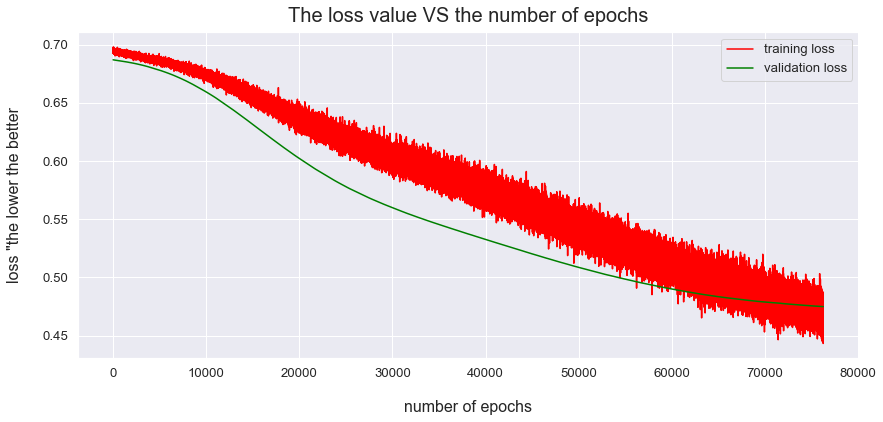

In [43]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [44]:
## loading the model with the best parameters
model1.load_state_dict(torch.load('checkpoint1.pth'))

<All keys matched successfully>

### Doing the inference

In [45]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model1.eval()

## moving the model back to the CPU
model1.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model1(test_inputs)
    
    ## claculating the test loss
    criterion = criterion.cpu()
    test_loss = criterion(predicted_output, test_labels)

    ## getting the probabilities using softmax function
    output = torch.softmax(predicted_output, dim=1)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [46]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))
print('\n'+ '#'*100 + '\n')
print(f'The test loss = {test_loss:.3f}')

the confusion matrix is:


,0,1
0,253,33
1,9,39



####################################################################################################

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       286
           1       0.54      0.81      0.65        48

    accuracy                           0.87       334
   macro avg       0.75      0.85      0.79       334
weighted avg       0.90      0.87      0.88       334


####################################################################################################

The test loss = 0.405


### Now let's try to build the models again using Adam optimizer

In [47]:
## create an instance of the network
model1 = Classifier1()

## moving the model to the GPU
model1.cuda()

## initiating the criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,6.2]).cuda())
optimizer = optim.Adam(model1.parameters(), lr=0.00001)

In [48]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model1.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model1(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model1.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model1(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model1.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 50:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint1.pth')

epoch =>    100 	 the training loss = 0.688 	 the validation loss = 0.682
epoch =>    200 	 the training loss = 0.689 	 the validation loss = 0.681
epoch =>    300 	 the training loss = 0.688 	 the validation loss = 0.679
epoch =>    400 	 the training loss = 0.681 	 the validation loss = 0.677
epoch =>    500 	 the training loss = 0.680 	 the validation loss = 0.675
epoch =>    600 	 the training loss = 0.681 	 the validation loss = 0.673
epoch =>    700 	 the training loss = 0.678 	 the validation loss = 0.672
epoch =>    800 	 the training loss = 0.675 	 the validation loss = 0.670
epoch =>    900 	 the training loss = 0.674 	 the validation loss = 0.668
epoch =>  1,000 	 the training loss = 0.673 	 the validation loss = 0.667
epoch =>  1,100 	 the training loss = 0.670 	 the validation loss = 0.665
epoch =>  1,200 	 the training loss = 0.674 	 the validation loss = 0.663
epoch =>  1,300 	 the training loss = 0.669 	 the validation loss = 0.661
epoch =>  1,400 	 the training loss = 

epoch =>  4,800 	 the training loss = 0.594 	 the validation loss = 0.579
epoch =>  4,900 	 the training loss = 0.597 	 the validation loss = 0.576
epoch =>  5,000 	 the training loss = 0.587 	 the validation loss = 0.574
epoch =>  5,100 	 the training loss = 0.581 	 the validation loss = 0.571
epoch =>  5,200 	 the training loss = 0.585 	 the validation loss = 0.569
epoch =>  5,300 	 the training loss = 0.591 	 the validation loss = 0.567
epoch =>  5,400 	 the training loss = 0.584 	 the validation loss = 0.564
epoch =>  5,500 	 the training loss = 0.571 	 the validation loss = 0.562
epoch =>  5,600 	 the training loss = 0.576 	 the validation loss = 0.560
epoch =>  5,700 	 the training loss = 0.579 	 the validation loss = 0.557
epoch =>  5,800 	 the training loss = 0.569 	 the validation loss = 0.555
epoch =>  5,900 	 the training loss = 0.582 	 the validation loss = 0.553
epoch =>  6,000 	 the training loss = 0.568 	 the validation loss = 0.551
epoch =>  6,100 	 the training loss = 

epoch =>  9,500 	 the training loss = 0.487 	 the validation loss = 0.498
epoch =>  9,600 	 the training loss = 0.492 	 the validation loss = 0.498
epoch =>  9,700 	 the training loss = 0.479 	 the validation loss = 0.497
epoch =>  9,800 	 the training loss = 0.494 	 the validation loss = 0.496
epoch =>  9,900 	 the training loss = 0.478 	 the validation loss = 0.495
epoch => 10,000 	 the training loss = 0.487 	 the validation loss = 0.495
epoch => 10,100 	 the training loss = 0.480 	 the validation loss = 0.494
epoch => 10,200 	 the training loss = 0.479 	 the validation loss = 0.493
epoch => 10,300 	 the training loss = 0.475 	 the validation loss = 0.493
epoch => 10,400 	 the training loss = 0.489 	 the validation loss = 0.492
epoch => 10,500 	 the training loss = 0.483 	 the validation loss = 0.491
epoch => 10,600 	 the training loss = 0.465 	 the validation loss = 0.491
epoch => 10,700 	 the training loss = 0.465 	 the validation loss = 0.490
epoch => 10,800 	 the training loss = 

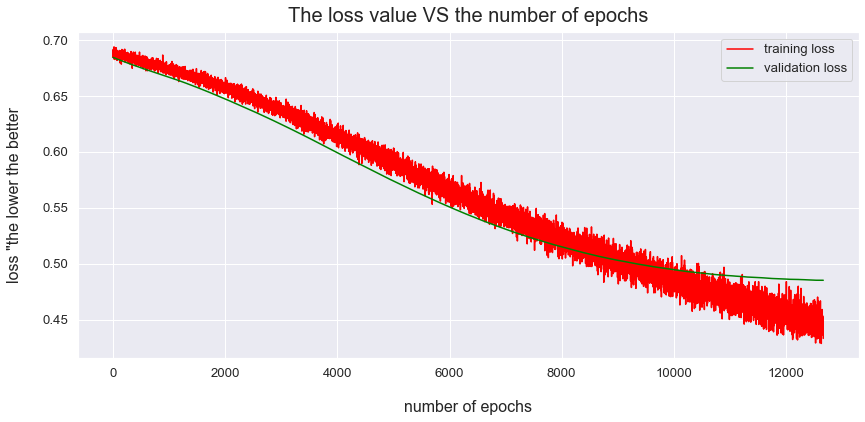

In [49]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [50]:
## loading the model with the best parameters
model1.load_state_dict(torch.load('checkpoint1.pth'))

<All keys matched successfully>

### Doing the inference

In [51]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model1.eval()

## moving the model back to the CPU
model1.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model1(test_inputs)
    
    ## claculating the test loss
    criterion = criterion.cpu()
    test_loss = criterion(predicted_output, test_labels)

    ## getting the probabilities using softmax function
    output = torch.softmax(predicted_output, dim=1)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [52]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))
print('\n'+ '#'*100 + '\n')
print(f'The test loss = {test_loss:.3f}')

the confusion matrix is:


,0,1
0,255,31
1,6,42



####################################################################################################

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       286
           1       0.58      0.88      0.69        48

    accuracy                           0.89       334
   macro avg       0.78      0.88      0.81       334
weighted avg       0.92      0.89      0.90       334


####################################################################################################

The test loss = 0.387


### Checking a different model with the same architecture

In [53]:
## create an instance of the network
model2 = Classifier2()

## moving the model to the GPU
model2.cuda()

## initiating the criterion and optimizer
criterion = nn.NLLLoss(weight=torch.Tensor([1,6.2]).cuda())
optimizer = optim.SGD(model2.parameters(), lr=0.001)

### Training the network

In [54]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model2.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model2(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model2.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model2(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model2.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 50:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint2.pth')

epoch =>    100 	 the training loss = 0.700 	 the validation loss = 0.698
epoch =>    200 	 the training loss = 0.697 	 the validation loss = 0.697
epoch =>    300 	 the training loss = 0.702 	 the validation loss = 0.696
epoch =>    400 	 the training loss = 0.695 	 the validation loss = 0.695
epoch =>    500 	 the training loss = 0.700 	 the validation loss = 0.694
epoch =>    600 	 the training loss = 0.694 	 the validation loss = 0.693
epoch =>    700 	 the training loss = 0.691 	 the validation loss = 0.692
epoch =>    800 	 the training loss = 0.697 	 the validation loss = 0.691
epoch =>    900 	 the training loss = 0.691 	 the validation loss = 0.690
epoch =>  1,000 	 the training loss = 0.693 	 the validation loss = 0.689
epoch =>  1,100 	 the training loss = 0.688 	 the validation loss = 0.688
epoch =>  1,200 	 the training loss = 0.687 	 the validation loss = 0.687
epoch =>  1,300 	 the training loss = 0.685 	 the validation loss = 0.686
epoch =>  1,400 	 the training loss = 

epoch =>  4,800 	 the training loss = 0.646 	 the validation loss = 0.643
epoch =>  4,900 	 the training loss = 0.655 	 the validation loss = 0.641
epoch =>  5,000 	 the training loss = 0.651 	 the validation loss = 0.640
epoch =>  5,100 	 the training loss = 0.647 	 the validation loss = 0.638
epoch =>  5,200 	 the training loss = 0.645 	 the validation loss = 0.637
epoch =>  5,300 	 the training loss = 0.645 	 the validation loss = 0.636
epoch =>  5,400 	 the training loss = 0.651 	 the validation loss = 0.634
epoch =>  5,500 	 the training loss = 0.638 	 the validation loss = 0.633
epoch =>  5,600 	 the training loss = 0.648 	 the validation loss = 0.631
epoch =>  5,700 	 the training loss = 0.647 	 the validation loss = 0.630
epoch =>  5,800 	 the training loss = 0.640 	 the validation loss = 0.628
epoch =>  5,900 	 the training loss = 0.638 	 the validation loss = 0.627
epoch =>  6,000 	 the training loss = 0.642 	 the validation loss = 0.625
epoch =>  6,100 	 the training loss = 

epoch =>  9,500 	 the training loss = 0.604 	 the validation loss = 0.577
epoch =>  9,600 	 the training loss = 0.607 	 the validation loss = 0.576
epoch =>  9,700 	 the training loss = 0.602 	 the validation loss = 0.575
epoch =>  9,800 	 the training loss = 0.582 	 the validation loss = 0.574
epoch =>  9,900 	 the training loss = 0.596 	 the validation loss = 0.573
epoch => 10,000 	 the training loss = 0.598 	 the validation loss = 0.572
epoch => 10,100 	 the training loss = 0.595 	 the validation loss = 0.571
epoch => 10,200 	 the training loss = 0.600 	 the validation loss = 0.570
epoch => 10,300 	 the training loss = 0.596 	 the validation loss = 0.568
epoch => 10,400 	 the training loss = 0.579 	 the validation loss = 0.567
epoch => 10,500 	 the training loss = 0.589 	 the validation loss = 0.566
epoch => 10,600 	 the training loss = 0.593 	 the validation loss = 0.565
epoch => 10,700 	 the training loss = 0.598 	 the validation loss = 0.564
epoch => 10,800 	 the training loss = 

epoch => 14,200 	 the training loss = 0.564 	 the validation loss = 0.535
epoch => 14,300 	 the training loss = 0.552 	 the validation loss = 0.534
epoch => 14,400 	 the training loss = 0.558 	 the validation loss = 0.533
epoch => 14,500 	 the training loss = 0.547 	 the validation loss = 0.533
epoch => 14,600 	 the training loss = 0.557 	 the validation loss = 0.532
epoch => 14,700 	 the training loss = 0.552 	 the validation loss = 0.531
epoch => 14,800 	 the training loss = 0.553 	 the validation loss = 0.531
epoch => 14,900 	 the training loss = 0.549 	 the validation loss = 0.530
epoch => 15,000 	 the training loss = 0.549 	 the validation loss = 0.530
epoch => 15,100 	 the training loss = 0.558 	 the validation loss = 0.529
epoch => 15,200 	 the training loss = 0.537 	 the validation loss = 0.528
epoch => 15,300 	 the training loss = 0.547 	 the validation loss = 0.528
epoch => 15,400 	 the training loss = 0.546 	 the validation loss = 0.527
epoch => 15,500 	 the training loss = 

epoch => 18,900 	 the training loss = 0.532 	 the validation loss = 0.509
epoch => 19,000 	 the training loss = 0.538 	 the validation loss = 0.508
epoch => 19,100 	 the training loss = 0.550 	 the validation loss = 0.508
epoch => 19,200 	 the training loss = 0.540 	 the validation loss = 0.507
epoch => 19,300 	 the training loss = 0.527 	 the validation loss = 0.507
epoch => 19,400 	 the training loss = 0.508 	 the validation loss = 0.506
epoch => 19,500 	 the training loss = 0.521 	 the validation loss = 0.506
epoch => 19,600 	 the training loss = 0.522 	 the validation loss = 0.506
epoch => 19,700 	 the training loss = 0.537 	 the validation loss = 0.505
epoch => 19,800 	 the training loss = 0.517 	 the validation loss = 0.505
epoch => 19,900 	 the training loss = 0.509 	 the validation loss = 0.504
epoch => 20,000 	 the training loss = 0.521 	 the validation loss = 0.504
epoch => 20,100 	 the training loss = 0.509 	 the validation loss = 0.503
epoch => 20,200 	 the training loss = 

epoch => 23,700 	 the training loss = 0.512 	 the validation loss = 0.490
epoch => 23,800 	 the training loss = 0.476 	 the validation loss = 0.490
epoch => 23,900 	 the training loss = 0.500 	 the validation loss = 0.489
epoch => 24,000 	 the training loss = 0.485 	 the validation loss = 0.489
epoch => 24,100 	 the training loss = 0.498 	 the validation loss = 0.489
epoch => 24,200 	 the training loss = 0.476 	 the validation loss = 0.489
epoch => 24,300 	 the training loss = 0.495 	 the validation loss = 0.488
epoch => 24,400 	 the training loss = 0.510 	 the validation loss = 0.488
epoch => 24,500 	 the training loss = 0.493 	 the validation loss = 0.488
epoch => 24,600 	 the training loss = 0.494 	 the validation loss = 0.487
epoch => 24,700 	 the training loss = 0.492 	 the validation loss = 0.487
epoch => 24,800 	 the training loss = 0.496 	 the validation loss = 0.487
epoch => 24,900 	 the training loss = 0.495 	 the validation loss = 0.486
epoch => 25,000 	 the training loss = 

epoch => 28,400 	 the training loss = 0.449 	 the validation loss = 0.478
epoch => 28,500 	 the training loss = 0.461 	 the validation loss = 0.477
epoch => 28,600 	 the training loss = 0.459 	 the validation loss = 0.477
epoch => 28,700 	 the training loss = 0.461 	 the validation loss = 0.477
epoch => 28,800 	 the training loss = 0.473 	 the validation loss = 0.477
epoch => 28,900 	 the training loss = 0.472 	 the validation loss = 0.477
epoch => 29,000 	 the training loss = 0.447 	 the validation loss = 0.476
epoch => 29,100 	 the training loss = 0.473 	 the validation loss = 0.476
epoch => 29,200 	 the training loss = 0.466 	 the validation loss = 0.476
epoch => 29,300 	 the training loss = 0.461 	 the validation loss = 0.476
epoch => 29,400 	 the training loss = 0.469 	 the validation loss = 0.476
epoch => 29,500 	 the training loss = 0.480 	 the validation loss = 0.475
epoch => 29,600 	 the training loss = 0.447 	 the validation loss = 0.475
epoch => 29,700 	 the training loss = 

epoch => 33,100 	 the training loss = 0.451 	 the validation loss = 0.470
epoch => 33,200 	 the training loss = 0.443 	 the validation loss = 0.470
epoch => 33,300 	 the training loss = 0.461 	 the validation loss = 0.470
epoch => 33,400 	 the training loss = 0.435 	 the validation loss = 0.470
epoch => 33,500 	 the training loss = 0.445 	 the validation loss = 0.470
epoch => 33,600 	 the training loss = 0.449 	 the validation loss = 0.469
epoch => 33,700 	 the training loss = 0.456 	 the validation loss = 0.469
epoch => 33,800 	 the training loss = 0.452 	 the validation loss = 0.469
epoch => 33,900 	 the training loss = 0.445 	 the validation loss = 0.469

The model is no longer training so terminating the training process
####################################################################################################
The model has trained for 33,902 epochs in total
####################################################################################################
Wall time: 1mi

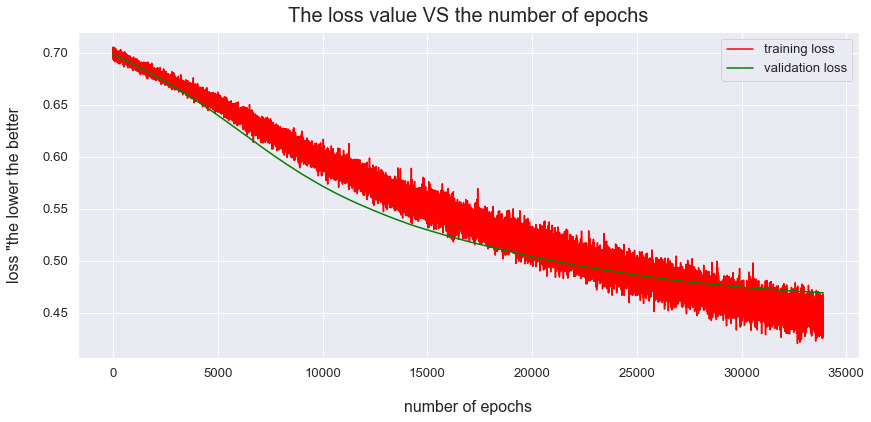

In [55]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [56]:
## loading the model with the best parameters
model2.load_state_dict(torch.load('checkpoint2.pth'))

<All keys matched successfully>

### Doing the inference

In [57]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model2.eval()

## moving the model back to the CPU
model2.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model2(test_inputs)
    
    ## claculating the test loss
    criterion = criterion.cpu()
    test_loss = criterion(predicted_output, test_labels)

    ## getting the probabilities using softmax function
    output = torch.exp(predicted_output)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [58]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))
print('\n'+ '#'*100 + '\n')
print(f'The test loss = {test_loss:.3f}')

the confusion matrix is:


,0,1
0,255,31
1,6,42



####################################################################################################

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       286
           1       0.58      0.88      0.69        48

    accuracy                           0.89       334
   macro avg       0.78      0.88      0.81       334
weighted avg       0.92      0.89      0.90       334


####################################################################################################

The test loss = 0.371


### Now let's try to build the models again using Adam optimizer

In [59]:
## create an instance of the network
model2 = Classifier2()

## moving the model to the GPU
model2.cuda()

## initiating the criterion and optimizer
criterion = nn.NLLLoss(weight=torch.Tensor([1,6.2]).cuda())
optimizer = optim.Adam(model2.parameters(), lr=0.00001)

### Training the network

In [60]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model2.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model2(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model2.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model2(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model2.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 50:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint2.pth')

epoch =>    100 	 the training loss = 0.702 	 the validation loss = 0.695
epoch =>    200 	 the training loss = 0.702 	 the validation loss = 0.694
epoch =>    300 	 the training loss = 0.697 	 the validation loss = 0.692
epoch =>    400 	 the training loss = 0.697 	 the validation loss = 0.691
epoch =>    500 	 the training loss = 0.695 	 the validation loss = 0.689
epoch =>    600 	 the training loss = 0.696 	 the validation loss = 0.687
epoch =>    700 	 the training loss = 0.694 	 the validation loss = 0.686
epoch =>    800 	 the training loss = 0.693 	 the validation loss = 0.684
epoch =>    900 	 the training loss = 0.691 	 the validation loss = 0.683
epoch =>  1,000 	 the training loss = 0.689 	 the validation loss = 0.681
epoch =>  1,100 	 the training loss = 0.690 	 the validation loss = 0.680
epoch =>  1,200 	 the training loss = 0.686 	 the validation loss = 0.678
epoch =>  1,300 	 the training loss = 0.686 	 the validation loss = 0.676
epoch =>  1,400 	 the training loss = 

epoch =>  4,800 	 the training loss = 0.619 	 the validation loss = 0.599
epoch =>  4,900 	 the training loss = 0.615 	 the validation loss = 0.597
epoch =>  5,000 	 the training loss = 0.611 	 the validation loss = 0.594
epoch =>  5,100 	 the training loss = 0.610 	 the validation loss = 0.592
epoch =>  5,200 	 the training loss = 0.609 	 the validation loss = 0.590
epoch =>  5,300 	 the training loss = 0.611 	 the validation loss = 0.588
epoch =>  5,400 	 the training loss = 0.602 	 the validation loss = 0.586
epoch =>  5,500 	 the training loss = 0.605 	 the validation loss = 0.584
epoch =>  5,600 	 the training loss = 0.593 	 the validation loss = 0.582
epoch =>  5,700 	 the training loss = 0.597 	 the validation loss = 0.580
epoch =>  5,800 	 the training loss = 0.602 	 the validation loss = 0.578
epoch =>  5,900 	 the training loss = 0.589 	 the validation loss = 0.576
epoch =>  6,000 	 the training loss = 0.588 	 the validation loss = 0.574
epoch =>  6,100 	 the training loss = 

epoch =>  9,500 	 the training loss = 0.547 	 the validation loss = 0.527
epoch =>  9,600 	 the training loss = 0.531 	 the validation loss = 0.526
epoch =>  9,700 	 the training loss = 0.517 	 the validation loss = 0.525
epoch =>  9,800 	 the training loss = 0.525 	 the validation loss = 0.524
epoch =>  9,900 	 the training loss = 0.529 	 the validation loss = 0.523
epoch => 10,000 	 the training loss = 0.527 	 the validation loss = 0.522
epoch => 10,100 	 the training loss = 0.535 	 the validation loss = 0.521
epoch => 10,200 	 the training loss = 0.521 	 the validation loss = 0.520
epoch => 10,300 	 the training loss = 0.525 	 the validation loss = 0.519
epoch => 10,400 	 the training loss = 0.502 	 the validation loss = 0.518
epoch => 10,500 	 the training loss = 0.516 	 the validation loss = 0.518
epoch => 10,600 	 the training loss = 0.494 	 the validation loss = 0.517
epoch => 10,700 	 the training loss = 0.515 	 the validation loss = 0.516
epoch => 10,800 	 the training loss = 

epoch => 14,200 	 the training loss = 0.466 	 the validation loss = 0.496
epoch => 14,300 	 the training loss = 0.463 	 the validation loss = 0.495
epoch => 14,400 	 the training loss = 0.446 	 the validation loss = 0.495
epoch => 14,500 	 the training loss = 0.479 	 the validation loss = 0.494
epoch => 14,600 	 the training loss = 0.453 	 the validation loss = 0.494
epoch => 14,700 	 the training loss = 0.451 	 the validation loss = 0.494
epoch => 14,800 	 the training loss = 0.458 	 the validation loss = 0.493
epoch => 14,900 	 the training loss = 0.457 	 the validation loss = 0.493
epoch => 15,000 	 the training loss = 0.463 	 the validation loss = 0.493
epoch => 15,100 	 the training loss = 0.441 	 the validation loss = 0.493
epoch => 15,200 	 the training loss = 0.450 	 the validation loss = 0.492

The model is no longer training so terminating the training process
####################################################################################################
The model has tr

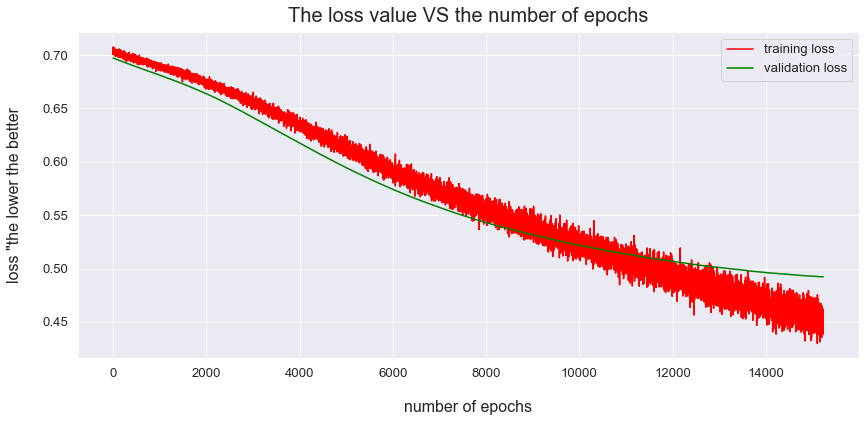

In [61]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [62]:
## loading the model with the best parameters
model2.load_state_dict(torch.load('checkpoint2.pth'))

<All keys matched successfully>

### Doing the inference

In [63]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model2.eval()

## moving the model back to the CPU
model2.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model2(test_inputs)
    
    ## claculating the test loss
    criterion = criterion.cpu()
    test_loss = criterion(predicted_output, test_labels)

    ## getting the probabilities using softmax function
    output = torch.exp(predicted_output)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [64]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))
print('\n'+ '#'*100 + '\n')
print(f'The test loss = {test_loss:.3f}')

the confusion matrix is:


,0,1
0,246,40
1,9,39



####################################################################################################

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       286
           1       0.49      0.81      0.61        48

    accuracy                           0.85       334
   macro avg       0.73      0.84      0.76       334
weighted avg       0.90      0.85      0.87       334


####################################################################################################

The test loss = 0.403


## Now time to try the dataset with the states columns
### Preparing the data

In [65]:
## loading the data from the saved csv files
train_data = pd.read_csv('train_m2.csv')
validation_data = pd.read_csv('validation_m2.csv')
test_data = pd.read_csv('test_m2.csv')

In [66]:
## dropping some redundant columns
train_data.drop(columns=["Int'l Plan_no", "VMail Plan_no"], inplace=True)
validation_data.drop(columns=["Int'l Plan_no", "VMail Plan_no"], inplace=True)
test_data.drop(columns=["Int'l Plan_no", "VMail Plan_no"], inplace=True)

### Building the data scaling function

In [67]:
## creating a scaler for the numeric columns needed to be scaled
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(train_data.values[:, 1:12])

### Scaling the data and Putting it in the proper format for PyTorch

In [68]:
## training data
train_data = train_data.values
train_data[:, 1:12] = feature_scaler.transform(train_data[:, 1:12])
inputs = torch.tensor(train_data[:, 1:]).float()
labels = torch.tensor(train_data[:, 0]).long()

## validation data
validation_data = validation_data.values
validation_data[:, 1:12] = feature_scaler.transform(validation_data[:, 1:12])
val_inputs = torch.tensor(validation_data[:, 1:]).float()
val_labels = torch.tensor(validation_data[:, 0]).long()

## testing data
test_data = test_data.values
test_data[:, 1:12] = feature_scaler.transform(test_data[:, 1:12])
test_inputs = torch.tensor(test_data[:, 1:]).float()
test_labels = torch.tensor(test_data[:, 0]).long()

### Building the network

In [69]:
class Classifier3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(inputs.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)
        self.drop = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        x = self.drop(F.relu(self.fc4(x)))
        x = self.fc5(x)
        
        return x

In [70]:
## create an instance of the network
model3 = Classifier3()

## moving the model to the GPU
model3.cuda()

## initiating the criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,6.2]).cuda())
optimizer = optim.SGD(model3.parameters(), lr=0.0005)

### Training the network

In [71]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model3.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model3(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model3.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model3(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model3.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 100:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint3.pth')

epoch =>    100 	 the training loss = 0.693 	 the validation loss = 0.689

The model is no longer training so terminating the training process
####################################################################################################
The model has trained for 101 epochs in total
####################################################################################################
Wall time: 360 ms


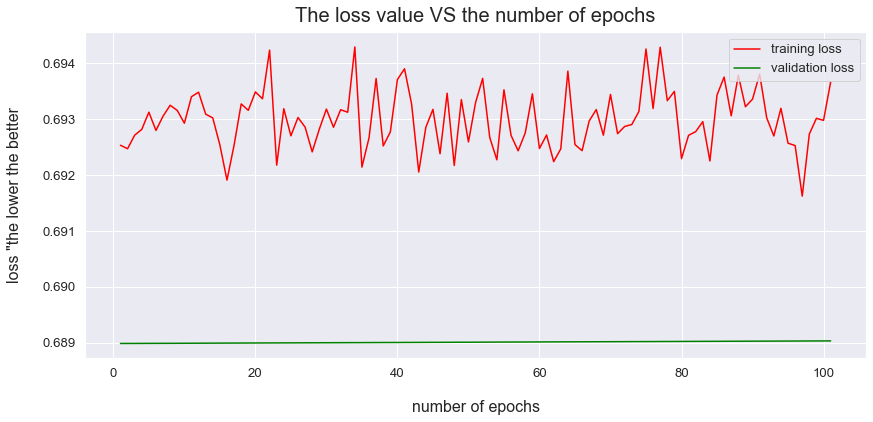

In [72]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [73]:
## loading the model with the best parameters
model3.load_state_dict(torch.load('checkpoint3.pth'))

<All keys matched successfully>

### Doing the inference

In [74]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model3.eval()

## moving the model back to the CPU
model3.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model3(test_inputs)
    
    ## claculating the test loss
    criterion = criterion.cpu()
    test_loss = criterion(predicted_output, test_labels)

    ## getting the probabilities using softmax function
    output = torch.softmax(predicted_output, dim=1)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [75]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))
print(f'The test loss = {test_loss:.3f}')

the confusion matrix is:


,0,1
0,0,286
1,0,48



####################################################################################################

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       286
           1       0.14      1.00      0.25        48

    accuracy                           0.14       334
   macro avg       0.07      0.50      0.13       334
weighted avg       0.02      0.14      0.04       334

The test loss = 0.692


C:\Users\nitro\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Now let's try to build the models again using Adam optimizer

In [76]:
## create an instance of the network
model3 = Classifier3()

## moving the model to the GPU
model3.cuda()

## initiating the criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,6.2]).cuda())
optimizer = optim.Adam(model3.parameters(), lr=0.000005)

### Training the network

In [77]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model3.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model3(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model3.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model3(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model3.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 100:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint3.pth')

epoch =>    100 	 the training loss = 0.698 	 the validation loss = 0.688
epoch =>    200 	 the training loss = 0.698 	 the validation loss = 0.688
epoch =>    300 	 the training loss = 0.698 	 the validation loss = 0.688
epoch =>    400 	 the training loss = 0.697 	 the validation loss = 0.688
epoch =>    500 	 the training loss = 0.697 	 the validation loss = 0.687
epoch =>    600 	 the training loss = 0.697 	 the validation loss = 0.687
epoch =>    700 	 the training loss = 0.696 	 the validation loss = 0.687
epoch =>    800 	 the training loss = 0.696 	 the validation loss = 0.687
epoch =>    900 	 the training loss = 0.696 	 the validation loss = 0.686
epoch =>  1,000 	 the training loss = 0.695 	 the validation loss = 0.686
epoch =>  1,100 	 the training loss = 0.695 	 the validation loss = 0.686
epoch =>  1,200 	 the training loss = 0.695 	 the validation loss = 0.685
epoch =>  1,300 	 the training loss = 0.694 	 the validation loss = 0.685
epoch =>  1,400 	 the training loss = 

epoch =>  4,800 	 the training loss = 0.613 	 the validation loss = 0.594
epoch =>  4,900 	 the training loss = 0.606 	 the validation loss = 0.591
epoch =>  5,000 	 the training loss = 0.606 	 the validation loss = 0.588
epoch =>  5,100 	 the training loss = 0.600 	 the validation loss = 0.585
epoch =>  5,200 	 the training loss = 0.601 	 the validation loss = 0.581
epoch =>  5,300 	 the training loss = 0.591 	 the validation loss = 0.578
epoch =>  5,400 	 the training loss = 0.589 	 the validation loss = 0.575
epoch =>  5,500 	 the training loss = 0.588 	 the validation loss = 0.572
epoch =>  5,600 	 the training loss = 0.584 	 the validation loss = 0.569
epoch =>  5,700 	 the training loss = 0.576 	 the validation loss = 0.565
epoch =>  5,800 	 the training loss = 0.578 	 the validation loss = 0.562
epoch =>  5,900 	 the training loss = 0.567 	 the validation loss = 0.559
epoch =>  6,000 	 the training loss = 0.566 	 the validation loss = 0.556
epoch =>  6,100 	 the training loss = 

epoch =>  9,500 	 the training loss = 0.422 	 the validation loss = 0.482
epoch =>  9,600 	 the training loss = 0.415 	 the validation loss = 0.481
epoch =>  9,700 	 the training loss = 0.411 	 the validation loss = 0.480
epoch =>  9,800 	 the training loss = 0.416 	 the validation loss = 0.480
epoch =>  9,900 	 the training loss = 0.418 	 the validation loss = 0.479
epoch => 10,000 	 the training loss = 0.403 	 the validation loss = 0.479
epoch => 10,100 	 the training loss = 0.395 	 the validation loss = 0.479
epoch => 10,200 	 the training loss = 0.406 	 the validation loss = 0.479

The model is no longer training so terminating the training process
####################################################################################################
The model has trained for 10,225 epochs in total
####################################################################################################
Wall time: 49.3 s


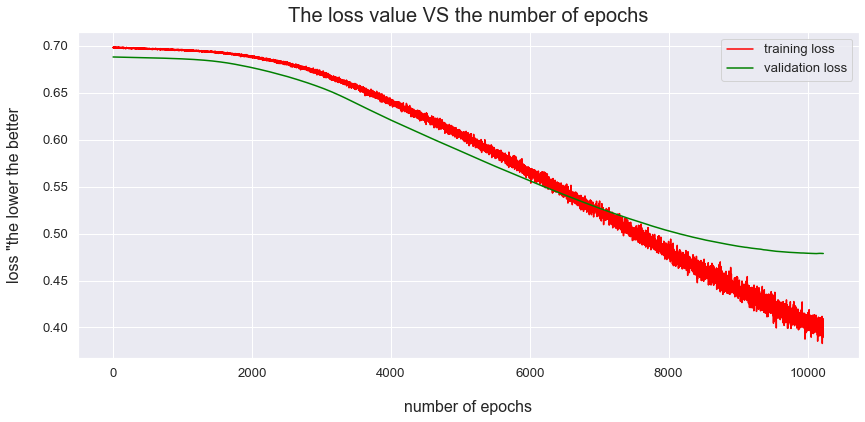

In [78]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [79]:
## loading the model with the best parameters
model3.load_state_dict(torch.load('checkpoint3.pth'))

<All keys matched successfully>

### Doing the inference

In [80]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model3.eval()

## moving the model back to the CPU
model3.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model3(test_inputs)
    
    ## claculating the test loss
    criterion = criterion.cpu()
    test_loss = criterion(predicted_output, test_labels)

    ## getting the probabilities using softmax function
    output = torch.softmax(predicted_output, dim=1)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [81]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))
print(f'The test loss = {test_loss:.3f}')

the confusion matrix is:


,0,1
0,254,32
1,11,37



####################################################################################################

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       286
           1       0.54      0.77      0.63        48

    accuracy                           0.87       334
   macro avg       0.75      0.83      0.78       334
weighted avg       0.90      0.87      0.88       334

The test loss = 0.443


### Checking a different model with the same architecture

In [82]:
class Classifier4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(inputs.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)
        self.drop = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        x = self.drop(F.relu(self.fc4(x)))
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

In [83]:
## create an instance of the network
model4 = Classifier4()

## moving the model to the GPU
model4.cuda()

## initiating the criterion and optimizer
criterion = nn.NLLLoss(weight=torch.Tensor([1,6.2]).cuda())
optimizer = optim.SGD(model4.parameters(), lr=0.0005)

### Training the network

In [84]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model4.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model4(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model4.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model4(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model4.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 50:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint4.pth')

epoch =>    100 	 the training loss = 0.693 	 the validation loss = 0.694
epoch =>    200 	 the training loss = 0.694 	 the validation loss = 0.694
epoch =>    300 	 the training loss = 0.693 	 the validation loss = 0.694
epoch =>    400 	 the training loss = 0.694 	 the validation loss = 0.694
epoch =>    500 	 the training loss = 0.693 	 the validation loss = 0.694
epoch =>    600 	 the training loss = 0.694 	 the validation loss = 0.694
epoch =>    700 	 the training loss = 0.693 	 the validation loss = 0.694
epoch =>    800 	 the training loss = 0.694 	 the validation loss = 0.694
epoch =>    900 	 the training loss = 0.694 	 the validation loss = 0.694
epoch =>  1,000 	 the training loss = 0.694 	 the validation loss = 0.694
epoch =>  1,100 	 the training loss = 0.693 	 the validation loss = 0.694
epoch =>  1,200 	 the training loss = 0.694 	 the validation loss = 0.694
epoch =>  1,300 	 the training loss = 0.693 	 the validation loss = 0.694
epoch =>  1,400 	 the training loss = 

epoch =>  4,800 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  4,900 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  5,000 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  5,100 	 the training loss = 0.694 	 the validation loss = 0.693
epoch =>  5,200 	 the training loss = 0.694 	 the validation loss = 0.693
epoch =>  5,300 	 the training loss = 0.694 	 the validation loss = 0.693
epoch =>  5,400 	 the training loss = 0.694 	 the validation loss = 0.693
epoch =>  5,500 	 the training loss = 0.694 	 the validation loss = 0.693
epoch =>  5,600 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  5,700 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  5,800 	 the training loss = 0.694 	 the validation loss = 0.693
epoch =>  5,900 	 the training loss = 0.694 	 the validation loss = 0.693
epoch =>  6,000 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  6,100 	 the training loss = 

epoch =>  9,500 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  9,600 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  9,700 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  9,800 	 the training loss = 0.693 	 the validation loss = 0.693
epoch =>  9,900 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 10,000 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 10,100 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 10,200 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 10,300 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 10,400 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 10,500 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 10,600 	 the training loss = 0.694 	 the validation loss = 0.693
epoch => 10,700 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 10,800 	 the training loss = 

epoch => 14,200 	 the training loss = 0.692 	 the validation loss = 0.693
epoch => 14,300 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 14,400 	 the training loss = 0.692 	 the validation loss = 0.693
epoch => 14,500 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 14,600 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 14,700 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 14,800 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 14,900 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 15,000 	 the training loss = 0.694 	 the validation loss = 0.693
epoch => 15,100 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 15,200 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 15,300 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 15,400 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 15,500 	 the training loss = 

epoch => 18,900 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 19,000 	 the training loss = 0.694 	 the validation loss = 0.693
epoch => 19,100 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 19,200 	 the training loss = 0.692 	 the validation loss = 0.693
epoch => 19,300 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 19,400 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 19,500 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 19,600 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 19,700 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 19,800 	 the training loss = 0.693 	 the validation loss = 0.693
epoch => 19,900 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 20,000 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 20,100 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 20,200 	 the training loss = 

epoch => 23,600 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 23,700 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 23,800 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 23,900 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 24,000 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 24,100 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 24,200 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 24,300 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 24,400 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 24,500 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 24,600 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 24,700 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 24,800 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 24,900 	 the training loss = 

epoch => 28,300 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 28,400 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 28,500 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 28,600 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 28,700 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 28,800 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 28,900 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 29,000 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 29,100 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 29,200 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 29,300 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 29,400 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 29,500 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 29,600 	 the training loss = 

epoch => 33,000 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,100 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,200 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,300 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,400 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,500 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,600 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,700 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,800 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 33,900 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 34,000 	 the training loss = 0.693 	 the validation loss = 0.692
epoch => 34,100 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 34,200 	 the training loss = 0.692 	 the validation loss = 0.692
epoch => 34,300 	 the training loss = 

epoch => 37,700 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 37,800 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 37,900 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 38,000 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 38,100 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 38,200 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 38,300 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 38,400 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 38,500 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 38,600 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 38,700 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 38,800 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 38,900 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 39,000 	 the training loss = 

epoch => 42,400 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 42,500 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 42,600 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 42,700 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 42,800 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 42,900 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 43,000 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 43,100 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 43,200 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 43,300 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 43,400 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 43,500 	 the training loss = 0.691 	 the validation loss = 0.691
epoch => 43,600 	 the training loss = 0.692 	 the validation loss = 0.691
epoch => 43,700 	 the training loss = 

epoch => 47,100 	 the training loss = 0.691 	 the validation loss = 0.690
epoch => 47,200 	 the training loss = 0.691 	 the validation loss = 0.690
epoch => 47,300 	 the training loss = 0.692 	 the validation loss = 0.690
epoch => 47,400 	 the training loss = 0.691 	 the validation loss = 0.690
epoch => 47,500 	 the training loss = 0.690 	 the validation loss = 0.690
epoch => 47,600 	 the training loss = 0.691 	 the validation loss = 0.690
epoch => 47,700 	 the training loss = 0.691 	 the validation loss = 0.690
epoch => 47,800 	 the training loss = 0.691 	 the validation loss = 0.690
epoch => 47,900 	 the training loss = 0.691 	 the validation loss = 0.690
epoch => 48,000 	 the training loss = 0.692 	 the validation loss = 0.690
epoch => 48,100 	 the training loss = 0.690 	 the validation loss = 0.690
epoch => 48,200 	 the training loss = 0.691 	 the validation loss = 0.690
epoch => 48,300 	 the training loss = 0.690 	 the validation loss = 0.690
epoch => 48,400 	 the training loss = 

epoch => 51,800 	 the training loss = 0.690 	 the validation loss = 0.690
epoch => 51,900 	 the training loss = 0.690 	 the validation loss = 0.689
epoch => 52,000 	 the training loss = 0.691 	 the validation loss = 0.689
epoch => 52,100 	 the training loss = 0.691 	 the validation loss = 0.689
epoch => 52,200 	 the training loss = 0.690 	 the validation loss = 0.689
epoch => 52,300 	 the training loss = 0.691 	 the validation loss = 0.689
epoch => 52,400 	 the training loss = 0.689 	 the validation loss = 0.689
epoch => 52,500 	 the training loss = 0.690 	 the validation loss = 0.689
epoch => 52,600 	 the training loss = 0.690 	 the validation loss = 0.689
epoch => 52,700 	 the training loss = 0.690 	 the validation loss = 0.689
epoch => 52,800 	 the training loss = 0.690 	 the validation loss = 0.689
epoch => 52,900 	 the training loss = 0.690 	 the validation loss = 0.689
epoch => 53,000 	 the training loss = 0.690 	 the validation loss = 0.689
epoch => 53,100 	 the training loss = 

epoch => 56,500 	 the training loss = 0.690 	 the validation loss = 0.688
epoch => 56,600 	 the training loss = 0.689 	 the validation loss = 0.688
epoch => 56,700 	 the training loss = 0.689 	 the validation loss = 0.688
epoch => 56,800 	 the training loss = 0.690 	 the validation loss = 0.688
epoch => 56,900 	 the training loss = 0.690 	 the validation loss = 0.688
epoch => 57,000 	 the training loss = 0.689 	 the validation loss = 0.688
epoch => 57,100 	 the training loss = 0.689 	 the validation loss = 0.688
epoch => 57,200 	 the training loss = 0.689 	 the validation loss = 0.688
epoch => 57,300 	 the training loss = 0.689 	 the validation loss = 0.688
epoch => 57,400 	 the training loss = 0.690 	 the validation loss = 0.688
epoch => 57,500 	 the training loss = 0.690 	 the validation loss = 0.688
epoch => 57,600 	 the training loss = 0.688 	 the validation loss = 0.688
epoch => 57,700 	 the training loss = 0.689 	 the validation loss = 0.688
epoch => 57,800 	 the training loss = 

epoch => 61,200 	 the training loss = 0.689 	 the validation loss = 0.687
epoch => 61,300 	 the training loss = 0.688 	 the validation loss = 0.687
epoch => 61,400 	 the training loss = 0.688 	 the validation loss = 0.687
epoch => 61,500 	 the training loss = 0.689 	 the validation loss = 0.687
epoch => 61,600 	 the training loss = 0.688 	 the validation loss = 0.687
epoch => 61,700 	 the training loss = 0.688 	 the validation loss = 0.686
epoch => 61,800 	 the training loss = 0.688 	 the validation loss = 0.686
epoch => 61,900 	 the training loss = 0.687 	 the validation loss = 0.686
epoch => 62,000 	 the training loss = 0.688 	 the validation loss = 0.686
epoch => 62,100 	 the training loss = 0.687 	 the validation loss = 0.686
epoch => 62,200 	 the training loss = 0.688 	 the validation loss = 0.686
epoch => 62,300 	 the training loss = 0.688 	 the validation loss = 0.686
epoch => 62,400 	 the training loss = 0.688 	 the validation loss = 0.686
epoch => 62,500 	 the training loss = 

epoch => 65,900 	 the training loss = 0.685 	 the validation loss = 0.684
epoch => 66,000 	 the training loss = 0.685 	 the validation loss = 0.684
epoch => 66,100 	 the training loss = 0.686 	 the validation loss = 0.684
epoch => 66,200 	 the training loss = 0.687 	 the validation loss = 0.684
epoch => 66,300 	 the training loss = 0.687 	 the validation loss = 0.684
epoch => 66,400 	 the training loss = 0.685 	 the validation loss = 0.684
epoch => 66,500 	 the training loss = 0.685 	 the validation loss = 0.684
epoch => 66,600 	 the training loss = 0.685 	 the validation loss = 0.683
epoch => 66,700 	 the training loss = 0.685 	 the validation loss = 0.683
epoch => 66,800 	 the training loss = 0.685 	 the validation loss = 0.683
epoch => 66,900 	 the training loss = 0.684 	 the validation loss = 0.683
epoch => 67,000 	 the training loss = 0.687 	 the validation loss = 0.683
epoch => 67,100 	 the training loss = 0.685 	 the validation loss = 0.683
epoch => 67,200 	 the training loss = 

epoch => 70,600 	 the training loss = 0.682 	 the validation loss = 0.680
epoch => 70,700 	 the training loss = 0.683 	 the validation loss = 0.679
epoch => 70,800 	 the training loss = 0.683 	 the validation loss = 0.679
epoch => 70,900 	 the training loss = 0.683 	 the validation loss = 0.679
epoch => 71,000 	 the training loss = 0.684 	 the validation loss = 0.679
epoch => 71,100 	 the training loss = 0.682 	 the validation loss = 0.679
epoch => 71,200 	 the training loss = 0.683 	 the validation loss = 0.679
epoch => 71,300 	 the training loss = 0.684 	 the validation loss = 0.679
epoch => 71,400 	 the training loss = 0.681 	 the validation loss = 0.679
epoch => 71,500 	 the training loss = 0.682 	 the validation loss = 0.678
epoch => 71,600 	 the training loss = 0.682 	 the validation loss = 0.678
epoch => 71,700 	 the training loss = 0.681 	 the validation loss = 0.678
epoch => 71,800 	 the training loss = 0.682 	 the validation loss = 0.678
epoch => 71,900 	 the training loss = 

epoch => 75,300 	 the training loss = 0.677 	 the validation loss = 0.671
epoch => 75,400 	 the training loss = 0.673 	 the validation loss = 0.671
epoch => 75,500 	 the training loss = 0.675 	 the validation loss = 0.671
epoch => 75,600 	 the training loss = 0.676 	 the validation loss = 0.671
epoch => 75,700 	 the training loss = 0.676 	 the validation loss = 0.671
epoch => 75,800 	 the training loss = 0.675 	 the validation loss = 0.670
epoch => 75,900 	 the training loss = 0.676 	 the validation loss = 0.670
epoch => 76,000 	 the training loss = 0.676 	 the validation loss = 0.670
epoch => 76,100 	 the training loss = 0.674 	 the validation loss = 0.669
epoch => 76,200 	 the training loss = 0.676 	 the validation loss = 0.669
epoch => 76,300 	 the training loss = 0.676 	 the validation loss = 0.669
epoch => 76,400 	 the training loss = 0.674 	 the validation loss = 0.669
epoch => 76,500 	 the training loss = 0.676 	 the validation loss = 0.668
epoch => 76,600 	 the training loss = 

epoch => 80,000 	 the training loss = 0.664 	 the validation loss = 0.657
epoch => 80,100 	 the training loss = 0.665 	 the validation loss = 0.656
epoch => 80,200 	 the training loss = 0.664 	 the validation loss = 0.656
epoch => 80,300 	 the training loss = 0.662 	 the validation loss = 0.655
epoch => 80,400 	 the training loss = 0.664 	 the validation loss = 0.655
epoch => 80,500 	 the training loss = 0.665 	 the validation loss = 0.655
epoch => 80,600 	 the training loss = 0.664 	 the validation loss = 0.654
epoch => 80,700 	 the training loss = 0.662 	 the validation loss = 0.654
epoch => 80,800 	 the training loss = 0.662 	 the validation loss = 0.653
epoch => 80,900 	 the training loss = 0.663 	 the validation loss = 0.653
epoch => 81,000 	 the training loss = 0.660 	 the validation loss = 0.652
epoch => 81,100 	 the training loss = 0.660 	 the validation loss = 0.652
epoch => 81,200 	 the training loss = 0.666 	 the validation loss = 0.652
epoch => 81,300 	 the training loss = 

epoch => 84,700 	 the training loss = 0.645 	 the validation loss = 0.632
epoch => 84,800 	 the training loss = 0.644 	 the validation loss = 0.632
epoch => 84,900 	 the training loss = 0.646 	 the validation loss = 0.631
epoch => 85,000 	 the training loss = 0.646 	 the validation loss = 0.630
epoch => 85,100 	 the training loss = 0.650 	 the validation loss = 0.630
epoch => 85,200 	 the training loss = 0.641 	 the validation loss = 0.629
epoch => 85,300 	 the training loss = 0.639 	 the validation loss = 0.628
epoch => 85,400 	 the training loss = 0.644 	 the validation loss = 0.628
epoch => 85,500 	 the training loss = 0.647 	 the validation loss = 0.627
epoch => 85,600 	 the training loss = 0.647 	 the validation loss = 0.626
epoch => 85,700 	 the training loss = 0.641 	 the validation loss = 0.625
epoch => 85,800 	 the training loss = 0.645 	 the validation loss = 0.625
epoch => 85,900 	 the training loss = 0.637 	 the validation loss = 0.624
epoch => 86,000 	 the training loss = 

epoch => 89,400 	 the training loss = 0.622 	 the validation loss = 0.595
epoch => 89,500 	 the training loss = 0.617 	 the validation loss = 0.594
epoch => 89,600 	 the training loss = 0.619 	 the validation loss = 0.593
epoch => 89,700 	 the training loss = 0.615 	 the validation loss = 0.592
epoch => 89,800 	 the training loss = 0.609 	 the validation loss = 0.591
epoch => 89,900 	 the training loss = 0.614 	 the validation loss = 0.590
epoch => 90,000 	 the training loss = 0.605 	 the validation loss = 0.589
epoch => 90,100 	 the training loss = 0.611 	 the validation loss = 0.589
epoch => 90,200 	 the training loss = 0.613 	 the validation loss = 0.588
epoch => 90,300 	 the training loss = 0.610 	 the validation loss = 0.587
epoch => 90,400 	 the training loss = 0.615 	 the validation loss = 0.586
epoch => 90,500 	 the training loss = 0.617 	 the validation loss = 0.585
epoch => 90,600 	 the training loss = 0.613 	 the validation loss = 0.584
epoch => 90,700 	 the training loss = 

epoch => 94,100 	 the training loss = 0.578 	 the validation loss = 0.553
epoch => 94,200 	 the training loss = 0.578 	 the validation loss = 0.552
epoch => 94,300 	 the training loss = 0.577 	 the validation loss = 0.551
epoch => 94,400 	 the training loss = 0.569 	 the validation loss = 0.550
epoch => 94,500 	 the training loss = 0.575 	 the validation loss = 0.550
epoch => 94,600 	 the training loss = 0.589 	 the validation loss = 0.549
epoch => 94,700 	 the training loss = 0.582 	 the validation loss = 0.548
epoch => 94,800 	 the training loss = 0.564 	 the validation loss = 0.547
epoch => 94,900 	 the training loss = 0.577 	 the validation loss = 0.546
epoch => 95,000 	 the training loss = 0.568 	 the validation loss = 0.546
epoch => 95,100 	 the training loss = 0.570 	 the validation loss = 0.545
epoch => 95,200 	 the training loss = 0.573 	 the validation loss = 0.544
epoch => 95,300 	 the training loss = 0.590 	 the validation loss = 0.543
epoch => 95,400 	 the training loss = 

epoch => 98,800 	 the training loss = 0.549 	 the validation loss = 0.520
epoch => 98,900 	 the training loss = 0.540 	 the validation loss = 0.520
epoch => 99,000 	 the training loss = 0.531 	 the validation loss = 0.519
epoch => 99,100 	 the training loss = 0.543 	 the validation loss = 0.519
epoch => 99,200 	 the training loss = 0.541 	 the validation loss = 0.518
epoch => 99,300 	 the training loss = 0.546 	 the validation loss = 0.518
epoch => 99,400 	 the training loss = 0.555 	 the validation loss = 0.517
epoch => 99,500 	 the training loss = 0.534 	 the validation loss = 0.517
epoch => 99,600 	 the training loss = 0.538 	 the validation loss = 0.516
epoch => 99,700 	 the training loss = 0.542 	 the validation loss = 0.516
epoch => 99,800 	 the training loss = 0.546 	 the validation loss = 0.515
epoch => 99,900 	 the training loss = 0.546 	 the validation loss = 0.515
epoch => 100,000 	 the training loss = 0.549 	 the validation loss = 0.514
epoch => 100,100 	 the training loss 

epoch => 103,500 	 the training loss = 0.505 	 the validation loss = 0.498
epoch => 103,600 	 the training loss = 0.506 	 the validation loss = 0.498
epoch => 103,700 	 the training loss = 0.508 	 the validation loss = 0.498
epoch => 103,800 	 the training loss = 0.501 	 the validation loss = 0.497
epoch => 103,900 	 the training loss = 0.509 	 the validation loss = 0.497
epoch => 104,000 	 the training loss = 0.515 	 the validation loss = 0.496
epoch => 104,100 	 the training loss = 0.502 	 the validation loss = 0.496
epoch => 104,200 	 the training loss = 0.506 	 the validation loss = 0.496
epoch => 104,300 	 the training loss = 0.514 	 the validation loss = 0.495
epoch => 104,400 	 the training loss = 0.513 	 the validation loss = 0.495
epoch => 104,500 	 the training loss = 0.498 	 the validation loss = 0.495
epoch => 104,600 	 the training loss = 0.498 	 the validation loss = 0.494
epoch => 104,700 	 the training loss = 0.514 	 the validation loss = 0.494
epoch => 104,800 	 the tr

epoch => 108,200 	 the training loss = 0.473 	 the validation loss = 0.483
epoch => 108,300 	 the training loss = 0.472 	 the validation loss = 0.483
epoch => 108,400 	 the training loss = 0.472 	 the validation loss = 0.483
epoch => 108,500 	 the training loss = 0.484 	 the validation loss = 0.482
epoch => 108,600 	 the training loss = 0.486 	 the validation loss = 0.482
epoch => 108,700 	 the training loss = 0.470 	 the validation loss = 0.482
epoch => 108,800 	 the training loss = 0.463 	 the validation loss = 0.482
epoch => 108,900 	 the training loss = 0.477 	 the validation loss = 0.482
epoch => 109,000 	 the training loss = 0.471 	 the validation loss = 0.481
epoch => 109,100 	 the training loss = 0.481 	 the validation loss = 0.481
epoch => 109,200 	 the training loss = 0.468 	 the validation loss = 0.481
epoch => 109,300 	 the training loss = 0.472 	 the validation loss = 0.481
epoch => 109,400 	 the training loss = 0.470 	 the validation loss = 0.480
epoch => 109,500 	 the tr

epoch => 112,900 	 the training loss = 0.456 	 the validation loss = 0.474
epoch => 113,000 	 the training loss = 0.465 	 the validation loss = 0.474
epoch => 113,100 	 the training loss = 0.460 	 the validation loss = 0.474
epoch => 113,200 	 the training loss = 0.443 	 the validation loss = 0.474
epoch => 113,300 	 the training loss = 0.444 	 the validation loss = 0.473
epoch => 113,400 	 the training loss = 0.427 	 the validation loss = 0.473
epoch => 113,500 	 the training loss = 0.444 	 the validation loss = 0.473
epoch => 113,600 	 the training loss = 0.439 	 the validation loss = 0.473
epoch => 113,700 	 the training loss = 0.432 	 the validation loss = 0.473
epoch => 113,800 	 the training loss = 0.444 	 the validation loss = 0.473
epoch => 113,900 	 the training loss = 0.455 	 the validation loss = 0.473
epoch => 114,000 	 the training loss = 0.457 	 the validation loss = 0.473
epoch => 114,100 	 the training loss = 0.454 	 the validation loss = 0.472
epoch => 114,200 	 the tr

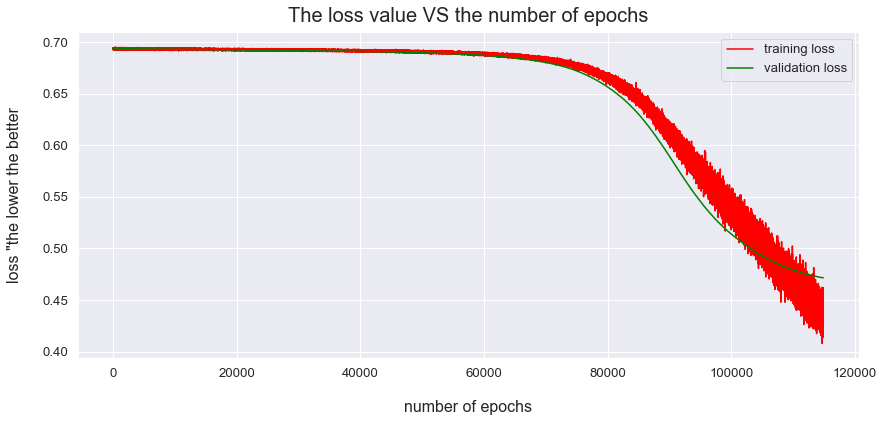

In [85]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [86]:
## loading the model with the best parameters
model4.load_state_dict(torch.load('checkpoint4.pth'))

<All keys matched successfully>

### Doing the inference

In [87]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model4.eval()

## moving the model back to the CPU
model4.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model4(test_inputs)
   
    ## getting the probabilities using softmax function
    output = torch.exp(predicted_output)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [88]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))

the confusion matrix is:


,0,1
0,254,32
1,7,41



####################################################################################################

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       286
           1       0.56      0.85      0.68        48

    accuracy                           0.88       334
   macro avg       0.77      0.87      0.80       334
weighted avg       0.91      0.88      0.89       334



### Now let's try to build the models again using Adam optimizer

In [89]:
## create an instance of the network
model4 = Classifier4()

## moving the model to the GPU
model4.cuda()

## initiating the criterion and optimizer
criterion = nn.NLLLoss(weight=torch.Tensor([1,6.2]).cuda())
optimizer = optim.Adam(model4.parameters(), lr=0.000005)

### Training the network

In [90]:
%%time

## training the model over the GPU

epoch = 0
stop_counter = 0
train_losses = []
val_losses = []

## moving the training data to the GPU
inputs, labels = inputs.cuda(), labels.cuda()

## moving the validation data to the GPU
val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

## set an initial value for the validation loss
initial_val_loss = np.inf

while True:

    ## increment the epoch number
    epoch += 1
    
    ## putting the model on the training mode
    model4.train()
    
    ## clearing the gradients:
    optimizer.zero_grad()
    
    ## forward pass for the network
    predicted_output = model4(inputs)
    
    ## calculating the loss
    loss = criterion(predicted_output, labels)
    
    ## taking a record of the training loss
    train_losses.append(loss.item())
    
    ## back propagation
    loss.backward()
    
    ## Take an update step and few the new weights
    optimizer.step()
    
    ## put the model on the evaluation mode
    model4.eval()

    ## check the model's performance over the validation data
    with torch.no_grad():

        ## forward pass for the network
        predicted_output = model4(val_inputs)

        ## calculating the loss
        val_loss = criterion(predicted_output, val_labels)
        
        ## taking a record of the validation loss
        val_losses.append(val_loss.item())
        
        ## incrementing the stop counter
        if val_loss < initial_val_loss:
            initial_val_loss = val_loss
            stop_counter = 0
            current_state_dict = model4.state_dict()
        else:
            stop_counter += 1

    ## print the loss from time to time and check the validation loss
    if (epoch) % 100 == 0:
        print(f"epoch => {epoch:{6},} \t the training loss = {loss:,.3f} \t the validation loss = {val_loss:,.3f}")
        print('='*100)
    
    ## early stopping the model to avoid overfitting
    if stop_counter == 50:
        print('\nThe model is no longer training so terminating the training process')
        print('#'*100)
        print(f'The model has trained for {epoch:,} epochs in total')
        print('#'*100)
        break

## saving a checkpoint for the best model
torch.save(current_state_dict, 'checkpoint4.pth')

epoch =>    100 	 the training loss = 0.715 	 the validation loss = 0.735
epoch =>    200 	 the training loss = 0.714 	 the validation loss = 0.734
epoch =>    300 	 the training loss = 0.714 	 the validation loss = 0.733
epoch =>    400 	 the training loss = 0.713 	 the validation loss = 0.732
epoch =>    500 	 the training loss = 0.712 	 the validation loss = 0.731
epoch =>    600 	 the training loss = 0.712 	 the validation loss = 0.730
epoch =>    700 	 the training loss = 0.711 	 the validation loss = 0.729
epoch =>    800 	 the training loss = 0.710 	 the validation loss = 0.729
epoch =>    900 	 the training loss = 0.710 	 the validation loss = 0.728
epoch =>  1,000 	 the training loss = 0.710 	 the validation loss = 0.727
epoch =>  1,100 	 the training loss = 0.709 	 the validation loss = 0.726
epoch =>  1,200 	 the training loss = 0.709 	 the validation loss = 0.725
epoch =>  1,300 	 the training loss = 0.708 	 the validation loss = 0.725
epoch =>  1,400 	 the training loss = 

epoch =>  4,800 	 the training loss = 0.596 	 the validation loss = 0.581
epoch =>  4,900 	 the training loss = 0.592 	 the validation loss = 0.577
epoch =>  5,000 	 the training loss = 0.594 	 the validation loss = 0.573
epoch =>  5,100 	 the training loss = 0.588 	 the validation loss = 0.568
epoch =>  5,200 	 the training loss = 0.586 	 the validation loss = 0.564
epoch =>  5,300 	 the training loss = 0.575 	 the validation loss = 0.561
epoch =>  5,400 	 the training loss = 0.571 	 the validation loss = 0.557
epoch =>  5,500 	 the training loss = 0.564 	 the validation loss = 0.553
epoch =>  5,600 	 the training loss = 0.563 	 the validation loss = 0.550
epoch =>  5,700 	 the training loss = 0.568 	 the validation loss = 0.547
epoch =>  5,800 	 the training loss = 0.554 	 the validation loss = 0.544
epoch =>  5,900 	 the training loss = 0.559 	 the validation loss = 0.540
epoch =>  6,000 	 the training loss = 0.553 	 the validation loss = 0.538
epoch =>  6,100 	 the training loss = 

epoch =>  9,500 	 the training loss = 0.401 	 the validation loss = 0.482
epoch =>  9,600 	 the training loss = 0.406 	 the validation loss = 0.482
epoch =>  9,700 	 the training loss = 0.406 	 the validation loss = 0.482

The model is no longer training so terminating the training process
####################################################################################################
The model has trained for 9,738 epochs in total
####################################################################################################
Wall time: 52.9 s


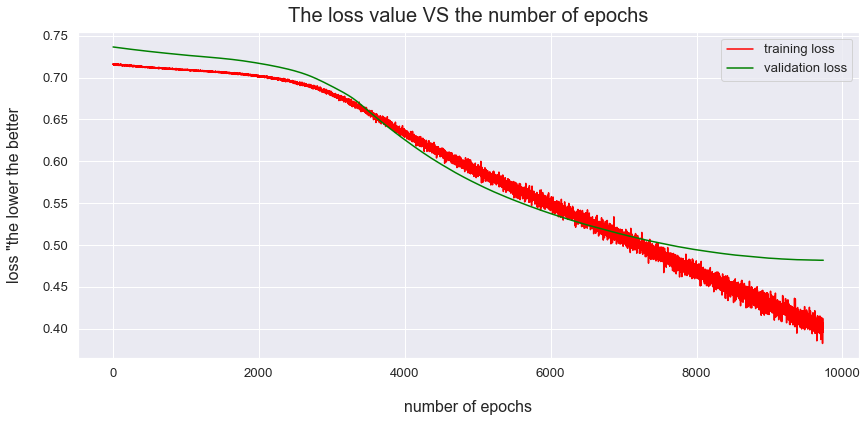

In [91]:
## visualizing the loss among different epochs
## using a static graph
plt.figure(figsize=(14,6))
ticks = [i for i in range(1,len(train_losses)+1)]

sns.lineplot(x=ticks, y=train_losses, label='training loss', color='red')
sns.lineplot(x=ticks, y=val_losses, label='validation loss', color='green')

plt.title('The loss value VS the number of epochs', pad=10, fontsize=20)
plt.xlabel('number of epochs', labelpad=20, fontsize=16)
plt.ylabel('loss "the lower the better', labelpad=20, fontsize=16)

plt.legend(loc='upper right')

plt.show();

In [92]:
## loading the model with the best parameters
model4.load_state_dict(torch.load('checkpoint4.pth'))

<All keys matched successfully>

### Doing the inference

In [93]:
## checking the model's predictions over the test data

## putting the model on evaluation mode
model4.eval()

## moving the model back to the CPU
model4.cpu()

with torch.no_grad():

    ## feeding the test_inputs to the model and getting the model's predictions
    predicted_output = model4(test_inputs)
   
    ## getting the probabilities using softmax function
    output = torch.exp(predicted_output)
    
    ## getting the predicted class and the model's probability for that class
    probability, pred = torch.max(output, 1)

In [94]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(test_labels, pred.numpy())))
print('\n'+ '#'*100 + '\n')
print(classification_report(test_labels, pred.numpy()))

the confusion matrix is:


,0,1
0,257,29
1,11,37



####################################################################################################

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       286
           1       0.56      0.77      0.65        48

    accuracy                           0.88       334
   macro avg       0.76      0.83      0.79       334
weighted avg       0.90      0.88      0.89       334



In [95]:
end_time = time.time()
time_consumed = end_time - start_time
print(f'The time taken so far = {time_consumed/60:.2f} mins')

The time taken so far = 19.90 mins


## Now let's try building models with XGBoost

In [96]:
## import XGBoost
import xgboost as xgb

### Loading again the dataset without the states without scaling

In [97]:
## loading the data from the saved csv files
train_data = pd.read_csv('train_m1.csv')
validation_data = pd.read_csv('validation_m1.csv')
test_data = pd.read_csv('test_m1.csv')

In [98]:
## training data
X_train = train_data.drop(columns='Churn?_True.')
y_train = train_data['Churn?_True.']

## validation data
X_valid = validation_data.drop(columns='Churn?_True.')
y_valid = validation_data['Churn?_True.']

## testing data
X_test = test_data.drop(columns='Churn?_True.')
y_test = test_data['Churn?_True.']

### Building the XGBoost model

In [99]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic')

### Training the model

In [100]:
## setting the hyperparameters and training the model
clf_xgb.fit(X_train,
            y_train,
            eval_metric='aucpr',
            early_stopping_rounds=10,
            verbose=True,
            eval_set=[(X_valid,y_valid)])

[0]	validation_0-aucpr:0.74947
[1]	validation_0-aucpr:0.75939
[2]	validation_0-aucpr:0.80329
[3]	validation_0-aucpr:0.80608
[4]	validation_0-aucpr:0.81956
[5]	validation_0-aucpr:0.82872
[6]	validation_0-aucpr:0.82872
[7]	validation_0-aucpr:0.83066
[8]	validation_0-aucpr:0.83014
[9]	validation_0-aucpr:0.82915
[10]	validation_0-aucpr:0.83109
[11]	validation_0-aucpr:0.83411
[12]	validation_0-aucpr:0.83435
[13]	validation_0-aucpr:0.83477
[14]	validation_0-aucpr:0.83629
[15]	validation_0-aucpr:0.83533
[16]	validation_0-aucpr:0.83452
[17]	validation_0-aucpr:0.83124
[18]	validation_0-aucpr:0.82852
[19]	validation_0-aucpr:0.82664
[20]	validation_0-aucpr:0.82647
[21]	validation_0-aucpr:0.82682
[22]	validation_0-aucpr:0.82787
[23]	validation_0-aucpr:0.83006
[24]	validation_0-aucpr:0.83135


C:\Users\nitro\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Testing the model

In [101]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(y_test.values, clf_xgb.predict(X_test))))
print('\n'+ '#'*100 + '\n')
print(classification_report(y_test.values, clf_xgb.predict(X_test)))

the confusion matrix is:


,0,1
0,282,4
1,10,38



####################################################################################################

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       286
           1       0.90      0.79      0.84        48

    accuracy                           0.96       334
   macro avg       0.94      0.89      0.91       334
weighted avg       0.96      0.96      0.96       334



### Loading again the dataset with the states and also without scaling

In [102]:
## loading the data from the saved csv files
train_data = pd.read_csv('train_m2.csv')
validation_data = pd.read_csv('validation_m2.csv')
test_data = pd.read_csv('test_m2.csv')

In [103]:
## training data
X_train = train_data.drop(columns='Churn?_True.')
y_train = train_data['Churn?_True.']

## validation data
X_valid = validation_data.drop(columns='Churn?_True.')
y_valid = validation_data['Churn?_True.']

## testing data
X_test = test_data.drop(columns='Churn?_True.')
y_test = test_data['Churn?_True.']

### Building the XGBoost model

In [104]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic')

### Training the model

In [105]:
## setting the hyperparameters and training the model
clf_xgb.fit(X_train,
            y_train,
            eval_metric='aucpr',
            early_stopping_rounds=10,
            verbose=True,
            eval_set=[(X_valid,y_valid)])

[0]	validation_0-aucpr:0.74947
[1]	validation_0-aucpr:0.75956
[2]	validation_0-aucpr:0.80190
[3]	validation_0-aucpr:0.80430
[4]	validation_0-aucpr:0.82023
[5]	validation_0-aucpr:0.82610
[6]	validation_0-aucpr:0.82878
[7]	validation_0-aucpr:0.83168
[8]	validation_0-aucpr:0.83074
[9]	validation_0-aucpr:0.83174
[10]	validation_0-aucpr:0.83310
[11]	validation_0-aucpr:0.83499
[12]	validation_0-aucpr:0.83525
[13]	validation_0-aucpr:0.83610
[14]	validation_0-aucpr:0.83527
[15]	validation_0-aucpr:0.83314
[16]	validation_0-aucpr:0.83639
[17]	validation_0-aucpr:0.83523
[18]	validation_0-aucpr:0.83604
[19]	validation_0-aucpr:0.83796
[20]	validation_0-aucpr:0.83655
[21]	validation_0-aucpr:0.83663
[22]	validation_0-aucpr:0.83609
[23]	validation_0-aucpr:0.83461
[24]	validation_0-aucpr:0.83483
[25]	validation_0-aucpr:0.83283
[26]	validation_0-aucpr:0.83289
[27]	validation_0-aucpr:0.83171
[28]	validation_0-aucpr:0.83073


C:\Users\nitro\Anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Testing the model

In [106]:
print('the confusion matrix is:')
display(pd.DataFrame(confusion_matrix(y_test.values, clf_xgb.predict(X_test))))
print('\n'+ '#'*100 + '\n')
print(classification_report(y_test.values, clf_xgb.predict(X_test)))

the confusion matrix is:


,0,1
0,283,3
1,10,38



####################################################################################################

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       286
           1       0.93      0.79      0.85        48

    accuracy                           0.96       334
   macro avg       0.95      0.89      0.92       334
weighted avg       0.96      0.96      0.96       334



## From this point onward, the code is provided by AWS and I have just added some comments to the code

Upload these files to Amazon S3, where SageMaker expects them.

boto is the standard Python library used to invoke AWS API. The same S3 bucket and prefix will be used for training and model data.  

This should be within the same region as the Notebook Instance, training, and hosting.

In [28]:
import os
import boto3
import sagemaker

sess = sagemaker.Session()

## creating a bucket over S3 to upload the data to
bucket = sess.default_bucket()

## the folder within the bucket
prefix = 'bootcamp-xgboost-churn'

## the following line of code does the following:
## 1. specifying the S3 service
## 2. choosing the Bucket inside S3, and passing the bucket name that has been created above
## 3. choose the location of the file to be uploaded to
## 4. choose which file to be uploaded "here the train.csv is the path to the file over our local disc"
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(
    prefix, 'validation/validation.csv')).upload_file('validation.csv')

## Train

Next, specify the locations of the XGBoost algorithm containers.

Amazon SageMaker algorithms are packaged as Docker images. This gives you the flexibility to use almost any algorithm code with Amazon SageMaker, regardless of implementation language, dependent libraries, frameworks, and so on.

In [29]:
# Set the IAM Role
from sagemaker import get_execution_role
role = get_execution_role()

# Get the XGBoost docker image
from sagemaker import image_uris
## the 3 arguments that the function below take are:
## framework = 'xgboost'
## region = boto3.Session().region_name
## version = '1.0-1' or else it's set to the default value which is None
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1.0-1')
display(container)

'246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

[SageMaker Python SDK](https://sagemaker.readthedocs.io/en/latest/) provides these high-level abstractions for working with Amazon SageMaker:

* Estimators: Encapsulates training on SageMaker.
* Models: Encapsulates built ML models.
* Predictors: Provides real-time inference and transformation using Python data-types against a SageMaker endpoint.
* Session: Provides a collection of methods for working with SageMaker resources.

Start by creating the [xgboost Estimator](https://sagemaker.readthedocs.io/en/latest/estimators.html). The mandatory paramters are: image_name, role, session, instance_type, and instance_count. 

For this training job, use:

* `image_uri = container`
* `role=role`
* `sagemaker_session = sess`
* `instance_count = 1`
* `instance_type = ml.m4.xlarge` 

### Exercise 3

Finish the Estimator definition. 

In [30]:
# Creating the SageMaker Estimator object
import sagemaker
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(
                                        bucket, prefix),
                                    sagemaker_session=sess)

An ML algorithm is configured and tuned based on its hyperparameters, which change the way the algorithem works.

The XGBoost hyperparamaters are described in the [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)

For this example, the required hyperparameters for XGBoost are:

* `objective` - Specifies the learning task and the corresponding learning objective. please use **binary:logistic** for binary classification task.  
* `num_round` - controls the number of rounds. Each round is trained using the output from the previous one. More rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.

A few other key hyperparameters are:

* `max_depth` controls how deep each tree within the algorithm can be built. Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting. There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
* `subsample` controls sampling of the training data. This technique can help reduce overfitting, but setting it too low can also starve the model of data.
* `eta` controls how aggressive each round of boosting is. Larger values lead to more conservative boosting.
* `gamma` controls how aggressively trees are grown. Larger values lead to more conservative models.

### Exercise 4

Use xgb.set_hyperparameters to set the hyperparameters.

In [31]:
# Set the hyperparameters
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

Then, because you're training with the CSV file format, create s3_inputs the training function can use as a pointer to the files in Amazon S3.

In [32]:
# Configuring the data inputs
s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Finally, you are ready to train. 

To train, use the fit() function.

In [33]:
%%time
# Training the model
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-03-02 11:46:31 Starting - Starting the training job...
2021-03-02 11:46:55 Starting - Launching requested ML instancesProfilerReport-1614685590: InProgress
......
2021-03-02 11:47:56 Starting - Preparing the instances for training.........
2021-03-02 11:49:29 Downloading - Downloading input data
2021-03-02 11:49:29 Training - Downloading the training image...
2021-03-02 11:50:02 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[11:50:04] 2333x66 matrix 

## Host

Now create a model and deploy it to a hosted endpoint using the deploy API of SageMaker [estimator](https://sagemaker.readthedocs.io/en/latest/estimators.html).  

### Exercise 5 
Configure `initial_instance_count = 1` , `instance_type = ml.m4.xlarge`, `serializer = CSVSerializer()`.
You set the csv serializer for passing the`test_data` arrays to the model that will be behind the endpoint.

In [34]:
# Deploy the model
Variant = 'AllTraffic'  # Configure the default deployment variant

from sagemaker.predictor import CSVSerializer

xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge',
                           serializer=CSVSerializer())

-------------!

### Evaluate

Now make real-time predictions from your model by making an http POST request.  

Use a simple function to:

1. Loop over your test dataset
2. Split it into mini-batches of rows 
3. Convert those mini-batchs to CSV string payloads
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint
5. Collect predictions and convert from the CSV output your model provides into a NumPy array

In [35]:
def predict(data, rows=500):
    ## getting a chunk "batch" of data with the desired size
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    ## passing one record a time of our batch to the model
    ## to get the model's prediction for that record
    for array in split_array:
        predictions = ','.join(
            [predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

## we convert the data from a pandas dataframe to a numpy array
## and we remove the first column "target variable" before passing
## the data to the model
predictions = predict(test_data.to_numpy()[:, 1:])

Assess the performance of your ML model by comparing actual values to predicted values.

In this case, you will predict whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

In [36]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(
    predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,283,3
1,11,37


_Note: Due to randomized elements of the algorithm, your results may differ slightly._

Of the 48 churners, 39 were correcly predicted. (True positives.) Four were incorrectly predited; they ended up not churning. (False postives.) 

Another nine customers did end up churning when we predicted they would not.  (False negatives.)

**Important:** Because of the`np.round()`function above, we are using a simple threshold (or cutoff) of 0.5.  

Our predictions from `xgboost` come out as continuous values between 0 and 1 and are forced into the binary classes that we began with.

## Automatically tune the model

### Model hyperparameter tuning for XGBoost

Automatic model tuning, or *hyperparameter tuning*, finds the best version of a model by running many jobs that test a range of hyperparameters on your dataset. 

You choose the tunable hyperparameters, a range of values for each, and an objective metric. Objective metrics are chosen from the metrics that the algorithm computes. 

Automatic model tuning searches the hyperparameters chosen to find the combination of values that result in the model that optimizes the objective metric.

For more information about model tuning, see [Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html).  

### Exercise 6

The HyperparameterTuner object takes the Estimator to obtain each job configuration information.

In [37]:
# Recreate the Estimator from above
xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(
                                        bucket, prefix),
                                    sagemaker_session=sess)

For each tuning job, you can configure a set of static hyperparameters and range of tuneable hyperparameters.  

Use the IntegerParameter, CategoricalParameter, and ContinuousParameter objects to assign values to the hyperparameter_ranges variable.  (This variable is a dictionary data type.)

### Exercise 7

Set the ranges for the job. 

In [38]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

xgb.set_hyperparameters(objective='binary:logistic',
                        num_round=10)
hyperparameter_ranges = {
    'eta': ContinuousParameter(0, 1),
    'min_child_weight': IntegerParameter(1, 10)
}

Next, specify the objective metric to tune and its definition.  The definition includes the regular expression (regex) needed to extract that metric from the CloudWatch logs of the training job. 

The XGBoost algorithm computes nine [metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) during training that can be used as objective metrics.

In this case, you only need to specify the metric name.  You do not need to provide regex. 

### Exercise 8

Choose one of the metrics as an objective. Choose an objective that will fit a binary classification.

In [39]:
# Compete the statement
objective_metric_name='validation:error'

Now, we'll create a HyperparameterTuner object, to which we pass:

* XGBoost estimator
* Hyperparameter ranges 
* Objective metric name
* Tunning job configuration

### Exercise 9

Create the [HyperparameterTuner](https://sagemaker.readthedocs.io/en/latest/tuner.html) object. 

The mandatory parameters are: 

* `estimator`
* `objective_metric_name`
* `hyperparameter_ranges`
* `objective_type`
* `max_jobs` 
* `max_parallel_jobs`


In [40]:
# Hyperparameter tunning job
from sagemaker.tuner import HyperparameterTuner

tuner = HyperparameterTuner(estimator=xgb,
                            objective_metric_name=objective_metric_name,
                            hyperparameter_ranges=hyperparameter_ranges,
                            objective_type='Minimize',
                            max_jobs=9,
                            max_parallel_jobs=3)

#### Build the training model!

In [41]:
%%time
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
tuner.wait()

..................................................................................................................................................!
!
CPU times: user 919 ms, sys: 35.4 ms, total: 954 ms
Wall time: 12min 18s


After tuning the model using the Hyperparameter tunning job, deploy the new model to the endpoint created previously.


## Deploy the new trained model

Amazon SageMaker includes built-in A/B testing capabilities that help you test your model and experiment with different versions to achieve the best results.  

Start by examining the results of the tuning job.

To monitor the progress and completion of the hyperparameter tuning job, check the section “Hyperparameter tuning jobs” section of the SageMaker console. 

This cell checks the status of hyperparameter tuning job, programatically.

In [42]:
from pprint import pprint
sage_client = sess.sagemaker_client
tuning_job_name = tuner.latest_tuning_job.job_name

# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print("The tuning job has not been completed.")

job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed\n" % job_count)

if tuning_job_result.get('BestTrainingJob', None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

9 training jobs have completed

Best model found so far:
{'CreationTime': datetime.datetime(2021, 3, 2, 13, 16, 9, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:error',
                                                 'Value': 0.06005999818444252},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2021, 3, 2, 13, 19, 36, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:645664661360:training-job/sagemaker-xgboost-210302-1315-003-5be36421',
 'TrainingJobName': 'sagemaker-xgboost-210302-1315-003-5be36421',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2021, 3, 2, 13, 18, 28, tzinfo=tzlocal()),
 'TunedHyperParameters': {'eta': '0.6949802579264392', 'min_child_weight': '3'}}


Once the training jobs have completed, deploy the best model to the endpoint.

In [43]:
# Create a SageMaker model from the best model
model_name = sess.create_model_from_job(training_job_name=tuner.best_training_job(),
                                        role=role)

From the model, create a new SageMaker endpoint configuration.

In [44]:
# Get the current endpoint configuration
endpoint = sage_client.describe_endpoint(EndpointName=xgb_predictor.endpoint_name)
endpoint_config = sage_client.describe_endpoint_config(
    EndpointConfigName=endpoint['EndpointConfigName'])

# Change the current deployment weight to 0.5 (we'll move 50% of the traffic to the new model)
current_model_config = endpoint_config['ProductionVariants'][0]
current_model_config['InitialVariantWeight'] = 0.5
current_model_config['VariantName'] = 'XGBoost'
Variant = 'TunedXGBoost'

tuned_model_config = {'ModelName': model_name,
                      'InitialInstanceCount': 1,
                      'InstanceType': 'ml.m4.xlarge',
                      'VariantName': Variant,
                      'InitialVariantWeight': 0.5}

# Create the new endpoint configuration
sage_client.create_endpoint_config(
    EndpointConfigName='AB-Config',
    ProductionVariants=[current_model_config,
                        tuned_model_config])

# Update the endpoint
sage_client.update_endpoint(
    EndpointName=endpoint['EndpointConfigName'],
    EndpointConfigName='AB-Config'
)
result = sess.wait_for_endpoint(endpoint['EndpointConfigName'])

---------------!

In the SageMaker console, you'll be able to see that the endpoint now sends 50 percent of the traffic to the old model and 50 percent of it to the new one.  

Create a new crosstab and make sure that everything works as expected. 

In [45]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join(
            [predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:, 1:])

pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(
    predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,281,5
1,10,38


If it worked as expected (no errors), you can send all traffic to the new model.

In [46]:
sage_client.update_endpoint_weights_and_capacities(
    EndpointName=endpoint['EndpointConfigName'],
    DesiredWeightsAndCapacities=[
        {
            'VariantName': Variant,
            'DesiredWeight': 1
        },
        {
            'VariantName': 'XGBoost',
            'DesiredWeight': 0
        }
    ]
)
response = sess.wait_for_endpoint(endpoint['EndpointConfigName'])

---!

Now, create a new crosstab for the new model.

In [47]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join(
            [predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:, 1:])

pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(
    predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,281,5
1,10,38


## Make the model production-ready

###  AWS Auto Scaling

As your endpoint goes into production, depending on your needs and expected traffic, throughput from a single endpoint might result in a bad experience under high load for users. 

Under heavy load, an endpoint behaves like a web server. When requests take more time to fulfill (the throughput of the endpoint is decreasing), the endpoint could start issuing errors due to timeouts and regular instance metrics (such as CPU utilization) will reach maximum utilization. 

In order to mitigate such a situation, you could provision more instances to back the endpoint serving your model, but this will not dynamically adapt to the traffic and load you are receiving. 

With AWS Auto Scaling for Amazon SageMaker, you don't have to closely monitor inference volume and manually change the endpoint configuration. Instead, configure a scaling policy to be used by AWS Auto Scaling. 

Auto Scaling adjusts the number of instances up or down in response to actual workloads, determined by using Amazon CloudWatch metrics and target values defined in the policy. 

Before putting AWS Auto Scaling in place for your last endpoint, first monitor how the endpoint behaves under load to understand which metrics to track. 

Create two helper functions that will be in charge of load testing the endpoint by sending requests with some sample data. 

In [48]:
import botocore
import concurrent.futures
import requests
import time

NB_CONNECTIONS = 200

# Update number of connections in the pool accepted by the sagemaker runtime client
client = boto3.client('sagemaker-runtime',
                      config=botocore.client.Config(max_pool_connections=NB_CONNECTIONS))
sess.sagemaker_runtime_client = client

# Send data for prediction to endpoint
def send_data():
    return xgb_predictor.predict([i for i in range(66)])

# Send nb_requests to endpoint nb_repetitions
def load_test_endpoint(nb_requests, nb_repetitions):
    for _ in range(nb_repetitions):
        out = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=NB_CONNECTIONS) as executor:
            future_submit = (executor.submit(send_data)
                             for _ in range(nb_requests))
            time1 = time.time()
            for future in concurrent.futures.as_completed(future_submit):
                try:
                    data = future.result()
                except Exception as exc:
                    data = str(type(exc))
                finally:
                    out.append(data)

                    print(str(len(out)), end="\r")

            time2 = time.time()

        # Print time taken for nb_requests
        print(f'Took {time2-time1:.2f} s for {nb_requests} requests')

Now use the helper function and send a batch of 200 requests, with 180 repetitions of this batch.  This should take, on average, less than a second.  The total run time will be just under 3 minutes. 

In [49]:
%%time
load_test_endpoint(nb_requests=200, nb_repetitions=180)

Took 1.09 s for 200 requests
Took 0.76 s for 200 requests
Took 0.59 s for 200 requests
Took 0.60 s for 200 requests
Took 0.60 s for 200 requests
Took 0.60 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.60 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.98 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.59 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.59 s for 200 requests
Took 0.60 s for 200 requests
Took 0.58 s for 200 requests
Took 0.60 s for 200 requests
Took 0.60 s for 200 requests
Took 0.60 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.60 s for 200 requests
Took 0.60 s for 200 requests
Took 0.59 s for 200 requests
Took 0.59 s fo

Put your endpoint under load by testing it with 50k requests. 

Keep it short, with only 1 repetition of the batch of 50k requests. 

You now have enough data points for measuring performance of the endpoint and you can display them using CloudWatch Metrics. 

Explore the different metrics available for your SageMaker endpoint, and make sure you can see metrics generated by the first load test you performed. 

On the SageMaker console, navigate to your endpoint and check out the links in the monitor section. Alternatively, run the following cell and open the link:

In [50]:
from IPython.display import Markdown as md

link = 'https://' + boto3.Session().region_name + '.console.aws.amazon.com/cloudwatch/home?region=' + boto3.Session().region_name + \
    '#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search=' + \
    xgb_predictor.endpoint_name

md("**Caution**: *Ctrl + click* the link to not loose the current tab with the notebook: [%s](%s)" % (link, link))

**Caution**: *Ctrl + click* the link to not loose the current tab with the notebook: [https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search=sagemaker-xgboost-2021-03-02-11-51-35-860](https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#metricsV2:namespace=AWS/SageMaker;dimensions=EndpointName,VariantName;search=sagemaker-xgboost-2021-03-02-11-51-35-860)

So that you can closely monitor the performance your endpoint, create a dashboard in Amazon CloudWatch with some of the metrics that you found above, set a scale of one hour's worth of data, and, if you prefer, set auto-refresh to avoid manually refreshing the dashboard.

Alternatively, we have provided a template Amazon CloudWatch dashboard you can automatically deploy using AWS CloudFormation. 

Download the template by opening `dashboard/template-cloudwatch.yaml` from the current folder. Then head over to AWS CloudFormation, and select 'Create Stack', and then 'Upload a template to Amazon S3' by selecting the downloaded template.

You will need the endpoint and variant name when you deploy it using AWS CloudFormation. Once created, you can look into the result of the deployment for a direct URL to the dashboard. 

In [51]:
variant_name = Variant

print("Endpoint name: " + xgb_predictor.endpoint)
print("Variant name: " + variant_name)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: sagemaker-xgboost-2021-03-02-11-51-35-860
Variant name: TunedXGBoost


Notice that most metrics went up with the final bigger batch of requests. Let's say that this endpoint is serving a large number of requests on a regular basis to determine whether customers are likely to churn, and we want to define a reasonable value for the desired throughput to sustain. We could measure this in Requests Per Minute (or RPS), and define that the endpoint needs to sustain up to 10,000 requests to provide answers to all customers before they experience delays or even errors.

Below we have defined a simple formula to compute the throughput value used to auto scale following the recommendations in the [load testing guide](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-scaling-loadtest.html). 

In [52]:
MAX_RPS = 10000 
SAFETY_FACTOR = .5

INVOCATIONS_PER_INSTANCE_THRESHOLD = (MAX_RPS * SAFETY_FACTOR)
print(INVOCATIONS_PER_INSTANCE_THRESHOLD)

5000.0


Note the safety factor, which is important as you need to account for situations where the endpoint might behave differently than when the load test was performed, and external factors out of your own reach. 

The result of this formula will be used as the threshold for the number of invocations per instance that when reached, will trigger the endpoint to auto scale and add an additional instance to back the endpoint. 

To achieve this objective, register a scalable target with AWS Auto Scaling to define what to auto-scale (e.g. the number of instances), as well as the minimum and maximum capacity.  

We recommend setting the minimum and maximum capacity to 1 and 3 respectively.

### Exercise 10

Fill out the details of this first step to set up AWS Auto Scaling. You can use the `register_scalable_target` [API method](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/application-autoscaling.html#ApplicationAutoScaling.Client.register_scalable_target) of the Auto Scaling API, and the pre-computed `resource_name` for the `ResourceId`. 

In [53]:
autoscaling_client = boto3.client('application-autoscaling')
resource_name = 'endpoint/' + xgb_predictor.endpoint_name + '/variant/' + variant_name

response = autoscaling_client.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=resource_name,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=3
)

Now that the endpoint's number of instances is registered as a scalable target, it's available to automatically scale up and down. 

To enable this behavior, create a scaling policy that defines what metrics AWS Auto Scaling needs to track and against what value. 

In this case, the endpoint should scale when the threshold we defined has been reached. 

### Exercise 11

Fill out the following code with the the metric and value you want to track. 

You can read more about the `put_scaling_policy` [API method](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/application-autoscaling.html#ApplicationAutoScaling.Client.put_scaling_policy) to understand how to complete the values. 

In [54]:
## Your solution goes here...

response = autoscaling_client.put_scaling_policy(
    PolicyName='xgb-endpoint-throughput-threshold',
    ServiceNamespace='sagemaker',
    ResourceId=resource_name,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': INVOCATIONS_PER_INSTANCE_THRESHOLD,
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance'
        },
        'ScaleOutCooldown': 200,
        'ScaleInCooldown': 200,
        'DisableScaleIn': False
    }
)

Put the endpoint under heavy load again and watch AWS Auto Scaling activate.  

Send it another batch of 50k requests and 10 repetitions.

In [55]:
%%time
load_test_endpoint(nb_requests=50000, nb_repetitions=10)

Took 152.55 s for 50000 requests
Took 151.02 s for 50000 requests
Took 149.21 s for 50000 requests
Took 152.63 s for 50000 requests
Took 151.41 s for 50000 requests
Took 153.29 s for 50000 requests
Took 153.01 s for 50000 requests
Took 153.23 s for 50000 requests
Took 151.66 s for 50000 requests
Took 151.46 s for 50000 requests
CPU times: user 29min 38s, sys: 1min 58s, total: 31min 37s
Wall time: 25min 19s


By looking at the dashboard created earlier, can you see when auto scaling kicked in? 

The number of invocations per instance should have dropped below the target, and the invocations graph will now display 2 separate lines for the Invocations and InvocationsPerInstance. 

This clearly indicates that the model is being served from multiple instances and decreases the load.

If you let the above cell continue to run for longer, you might witness the endpoint scaling in. It will go back to a single instance. 

With multiple instances behind an endpoint, you are maintaining a throughput lower on average than the target we set. AWS Auto Scaling is set up to track 5000 requests per minute. An alarm will trigger an auto-scaling policy if too many data points are under 5000, which can be the case here. 

In a production setting, you would use a more robust load testing tool to perform a true load test and determine the exact throughput (or other metric) that your endpoint can sustain under heavy load until it starts responding with errors. 

For more information on the topic, a [blog post](https://aws.amazon.com/blogs/machine-learning/load-test-and-optimize-an-amazon-sagemaker-endpoint-using-automatic-scaling/) is available.  

### Relative cost of errors

#### Binary classification cutoff

Let us return now to model evaluation and chosing a cutoff value to turn the model prediction into a binary decision. 

Dealing with a churning customer is more expensive than working to retain a customer who *might* churn&mdash;so consider adjusting this cutoff to minimize costly false negatives.  This may increase the number of false positives, but it should also increase the number of true positives while reducing the number of false negatives.

To get a rough intuition here, look at the continuous values of your predictions.

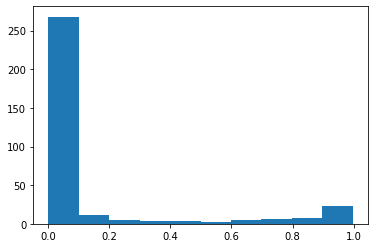

In [56]:
plt.hist(predictions)
plt.show()

The continuous valued predictions from the model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9. Adjusting the cutoff should shift a number of customer predictions.  

Compare the original confusion matrix with a cutoff of 0.5 to one with a cutoff of 0.3.

In [57]:
display(pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(
    predictions), rownames=['actual'], colnames=['predictions']))
display(pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(
    predictions > 0.3, 1, 0), rownames=['actual'], colnames=['predictions']))

predictions,0.0,1.0
actual,,
0,281,5
1,10,38


predictions,0,1
actual,,
0,278,8
1,7,41


We can see that changing the cutoff from 0.5 to 0.3 results in two fewer true negatives, seven more true positives, two additional false positives, and seven fewer false negatives.  

The numbers may look small, but that's 5 percent of customers, overall, who are shifting because of a change to the cutoff.  

Was this the right decision?  

You may end up retaining seven more customers, but you also unnecessarily incentivized two more customers who would have stayed without those incentives.  

Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.

#### Normalizing the output

Now, let's define a helper function that, in addition to computing the above confusion matrix, also "normalizes" it.  

Instead of showing the absolute counts, you can now see percentages.

In [58]:
def confusion_matrix(test_data, predictions, cutoff):
    conf_matrix = pd.crosstab(index=np.append(test_data.iloc[:, 0], [0,1]), columns=np.append(np.where(
        predictions > cutoff, 1, 0), [0,1]), rownames=['actual'], colnames=['predictions'])
    conf_matrix.iat[0,0]-=1
    conf_matrix.iat[1,1]-=1
    conf_matrix_normalized = conf_matrix/conf_matrix.values.sum()
    return conf_matrix_normalized

confusion_matrix(test_data, predictions, 0.5)

predictions,0,1
actual,,
0,0.841317,0.014970
1,0.029940,0.113772


#### Taking relative cost of errors into account

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with. You might even be able to solve it with simple rules instead of ML.

More important, if you put an ML model into production, *you will have to pay for false postiives and false negatives.*

Consider similar costs associated with correct predictions of true positives and true negatives.  The choice of the cutoff affects all four of these statistics. Be mindful of the relative costs to the business for each of these four outcomes per prediction.

#### Assigning costs

The costs for a mobile phone service provider's churn depend on the specific action that the business takes.

Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Your model essentially correctly identified a happy customer in this case, and you don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. You lose the customer and will have to pay all the costs of acquiring a replacement customer. 

These costs include:

* Foregone revenue
* Advertising costs
* Administrative costs
* Point of sale costs
* Phone hardware subsidies

A quick search on the Internet reveals that such costs typically run in the hundreds of dollars.  So, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that your model identifies as churning, let's assume a retention incentive in the amount of 
\\$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. 

In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \\$100 concession. We probably could have spent that \\$100 more effectively, but it's possible that we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  You need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  

Below, we test 100 possible values in the for loop.

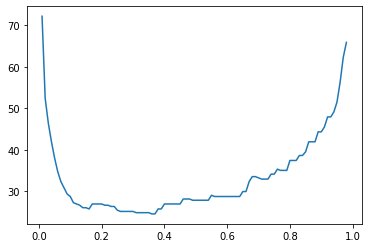

Cost is minimized near a cutoff of: 0.36000000000000004 for a cost of: 24.550898203592812


In [59]:
COST_OF_ERRORS = np.array([[0, 100], [500, 100]])

cutoffs = np.arange(0.01, .99, 0.01)
costs = []
for c in cutoffs:
    cost = (COST_OF_ERRORS * confusion_matrix(test_data,
                                              predictions, c)).values.sum()
    costs.append(cost)

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:',
      cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

The above chart shows that when you set a threshold that's too low, your costs skyrocket because all customers are given a retention incentive.

Meanwhile, setting the threshold too high results in too many lost customers, which is, ultimately, nearly as costly.

The overall cost can be minimized to \$24.55 by setting the cutoff to 0.29.

How does this compare not using an ML model at all?  That is, not giving any incentives and losing all customers that would churn.

Assume that the corresponding confusion matrix looks like this:

In [60]:
no_ml_confusion_matrix = np.array([[0.855086, 0], [1-0.855086, 0]])

display((COST_OF_ERRORS * no_ml_confusion_matrix).sum())

72.457

The cost per customer of not using the ML model and while maintaining the same pool of customers is substatially higher: $\$$72.46 versus $\$$24.55


## Extensions

This notebook showed you how to build a model that predicts whether a customer is likely to churn, and then how to optimally set a threshold that accounts for the cost of true positives, false positives, and false negatives.  

There are several ways to extend it including:

* Some customers who receive retention incentives will still churn.  Including a probability of churning despite receiving an incentive in your cost function would provide a better ROI on our retention programs.
* Customers who switch to a lower-priced plan or who deactivate a paid feature represent different kinds of churn that could be modeled separately.
* Modeling the evolution of customer behavior. If usage is dropping and the number of calls placed to Customer Service is increasing, you are more likely to experience churn then if the trend is the opposite. A customer profile should incorporate behavior trends.
* Actual training data and monetary cost assignments could be more complex.
* Multiple models for each type of churn could be needed.

Regardless of additional complexity, similar principles described in this notebook likely apply.

### Clean-up

If you're done with this notebook, please run the cell below to remove the hosted endpoint and avoid any charges from any stray instances being left on.

In [61]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint_name)